# Project jupyter notebook
# *Historical Hourly Weather Data*
## **Data Driven Engineering I**
## Institute of Thermal Turbomachinery (ITS)
## *Karlsruhe Institute of Technology*
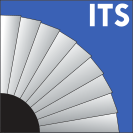

### **Joel Arweiler**
### Matr.-Nr.: 1964518
### E-Mail: uveea@student.kit.edu


---




# 1. Analysis of the problem




## Motivation and problem description
**Weather forecasts** play a crucial role not only in everyday life, but also in business. Nowadays, weather data is generated from various sources and combined into a model that makes it possible to predict the weather for the next few days. Nevertheless, a lot of factors have an influence on the weather pattern, which is why an accurate forecast of the weather for more than a few days is fraught with great uncertainty. The prediction of the weather with **machine learning algorithm** is the main part of this project. 

Weather data also plays a crucial role in the aviation industry. Less delays on the ground and more efficient flight routes between thunderstorms can be achieved with accurate weather data. Therefore, at the end of the project, an attempt will be made to find a correlation between weather data and flight delays.

## Dataset Description
"*The dataset contains ~5 years of high temporal resolution (hourly measurements) data of various weather attributes, such as temperature, humidity, air pressure, etc.
This data is available for 30 US and Canadian Cities, as well as 6 Israeli cities.
I've organized the data according to a common time axis for easy use.
Each attribute has it's own file and is organized such that the rows are the time axis (it's the same time axis for all files), and the columns are the different cities (it's the same city ordering for all files as well).
Additionally, for each city we also have the country, latitude and longitude information in a separate file.*"

Ref.: https://www.kaggle.com/selfishgene/historical-hourly-weather-data

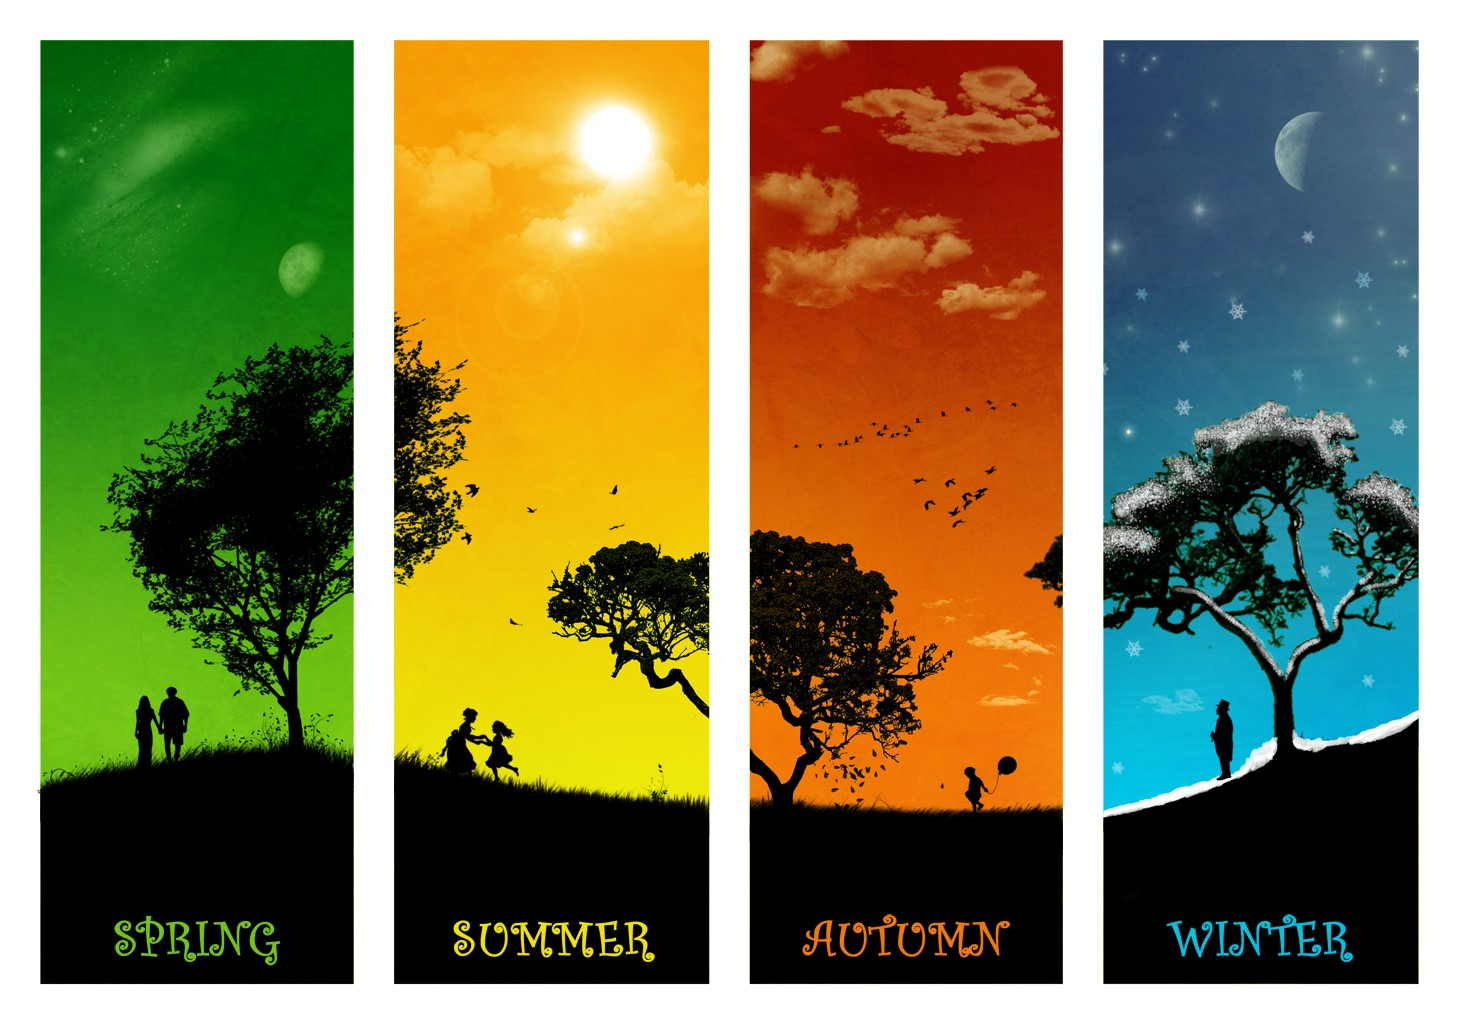

## Objective and solution methods

The objective of the work is to

- to be able to predict individual weather parameters (e.g. temperature)
- to predict a rough description of the future weather

Both objectives are realized with baseline models as well as with artificial neural networks.

In addition, the following methods are incorporated:

- Dimensionality reduction with Principal Component Analysis (PCA)
- Dealing with imbalanced data
- Multiclass classification
- One-hot-encoding for multiclass problems

In addition, for study purposes only, I will start with the implementation of a simple classification algorithm that predicts, whether a city is located in North America or in the Middle East with a few sample data.


## Preparing the environment

In [1]:
%%capture 
!pip install ipython-autotime
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6
%load_ext autotime
%unload_ext google.colab.data_table

time: 2.85 ms (started: 2021-04-18 18:35:51 +00:00)


In [2]:
%%capture
#Importing the necessary libraries
import numpy as np
import pandas as pd
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import datetime as dt
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import plotly.graph_objects as go
from google.colab import files

time: 2.79 s (started: 2021-04-18 18:35:51 +00:00)


In [3]:
%%capture
# Data Preparation
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV

time: 452 ms (started: 2021-04-18 18:35:54 +00:00)


In [4]:
%%capture
# ML Algorithms to be used

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Time Series Analysis - SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SVM
from sklearn.svm import SVR

# PCA
from sklearn.decomposition import PCA
#from sklearn.decomposition import KernelPCA

# LightGBM
import lightgbm as LGBMClassifier

# NN
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
from keras import backend as K


time: 1.69 s (started: 2021-04-18 18:35:54 +00:00)


## Useful self-implemented functions

In [5]:
def checkNaN(nandata):
  """
  Returns number of number of NaN values for an input dataset
  """
  nanCounter = np.isnan(nandata).sum()
  print(nanCounter)

time: 3.66 ms (started: 2021-04-18 18:35:56 +00:00)


In [6]:
def download_data(datadict):
  """
  Loads data from Google Drive

  Example:
  datadict = {
  "key_name":      {"id": "1TMqqpQgzYH7Ck5x-N31hPJhZKMOdptqF", "csv": "key_name.csv"},
  ...
}
  """
  downloaded_data = []
  keys_list = list(datadict)
  # Load files from Google Drive
  for i in range(len(datadict)):
    tmp_id = datadict[ keys_list[i] ]["id"]
    downloaded_data.append( drive.CreateFile({'id': tmp_id}) )
    downloaded_data[i].GetContentFile(datadict[ keys_list[i] ]["csv"])


time: 5.2 ms (started: 2021-04-18 18:35:56 +00:00)


In [7]:
def get_city_dataset(city):
  """
  Combining data from each *.csv files to one single file for selected city
  """
  data_TA = pd.concat([data['humidity'][city], data['pressure'][city], data['temperature'][city], data['weather_description'][city], data['wind_direction'][city], data['wind_speed'][city]], axis=1,ignore_index=True)
  data_TA.columns = ['humidity', 'pressure', 'temperature', 'weather_description', 'wind_direction', 'wind_speed']
  data_TA.set_index(datetime_index)
  data_TA = data_TA.dropna()
  data_TA = data_TA.sort_index()
  data_TA.name = city
  return data_TA

time: 9.44 ms (started: 2021-04-18 18:35:56 +00:00)


In [8]:
def shift_column_last_position(X, column_name):
  """
  Input: DataFrame: X, column name: column_name
  Output: DataFrame: X
  Shift column "column_name" to the last column
  """
  last_column = X.pop(column_name)
  X.insert(5, column_name, last_column)

time: 3.2 ms (started: 2021-04-18 18:35:56 +00:00)


In [9]:
def add_1hot_data(data):
  index = pd.DatetimeIndex(data.index)
  if 'weather_description' in data:
    weather_description_1hot_np = pd.get_dummies(data['weather_description'].values)
    weather_description_1hot = pd.DataFrame(weather_description_1hot_np)
    data = data.drop('weather_description', axis=1)
    data.reset_index(drop=True, inplace=True)
    weather_description_1hot.reset_index(drop=True, inplace=True)
    data = pd.concat([data, weather_description_1hot], axis=1)
    data.index = index
    output_data = data
    return output_data
  elif 'weather_description1' in data:
    windows_size = 4
    data_splitted = np.array_split(data,windows_size,axis=1)
    for i in range(0,windows_size):
      weather_description_1hot_np = pd.get_dummies(data_splitted[i]['weather_description'+str(i+1)].values)
      weather_description_1hot = pd.DataFrame(weather_description_1hot_np)
      data_splitted[i] = data_splitted[i].drop('weather_description'+str(i+1), axis=1)
      data_splitted[i].reset_index(drop=True, inplace=True)
      weather_description_1hot.reset_index(drop=True, inplace=True)
      data_splitted[i] = pd.concat([data_splitted[i], weather_description_1hot], axis=1)
      data_splitted[i].index = index
      column_names.append(['humidity_'+str(i+1),'pressure_'+str(i+1),'temperature_'+str(i+1),'wind_direction'+str(i+1), 'wind_speed'+str(i+1),'1'+str(i+1),'2'+str(i+1),'3'+str(i+1),'4'+str(i+1),'5'+str(i+1),'6'+str(i+1),'7'+str(i+1)])
      column_names_flattened = [val for sublist in column_names for val in sublist]
    output_data = pd.DataFrame(np.concatenate(data_splitted,axis=1),index=index, columns=column_names_flattened)
    return output_data
  else:
    raise ValueError("Dataset must have column 'weather_description' or 'weather_description1'")

  

time: 29.2 ms (started: 2021-04-18 18:35:56 +00:00)


In [10]:
def inverse_transform_1hot(df, column_names_list):
  """
  Transforms the one-hot-encoded data back to categorical data
  """
  Y_int = []
  Y_str = []

  for index in df.index:
    unsortedList = list(df.loc[index])
    sortedList   = list(df.loc[index].sort_values())
    # Find max value
    max_value  = max(sortedList)

    # Find max value index
    max_value_index  = unsortedList.index(max_value)

    weather_description = column_names_list[max_value_index]
    Y_int.append(max_value_index)
    Y_str.append(weather_description)
  return Y_int, Y_str
    

time: 12.1 ms (started: 2021-04-18 18:35:56 +00:00)


In [11]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
  """
  Generates scatter_hist plot
  """
  # no labels
  ax_histx.tick_params(axis="x", labelbottom=False)
  ax_histy.tick_params(axis="y", labelleft=False)

  # the scatter plot:
  ax.scatter(x, y)

  # now determine nice limits by hand:
  binwidth = 0.25
  xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
  lim = (int(xymax/binwidth) + 1) * binwidth

  bins = np.arange(-lim, lim + binwidth, binwidth)
  ax_histx.hist(x, bins=bins)
  ax_histy.hist(y, bins=bins, orientation='horizontal')

time: 9.02 ms (started: 2021-04-18 18:35:56 +00:00)


In [12]:
def plotResults(trueLabels, anomalyScore, returnPreds = False, plotting = True):
  """
  Generates plotResult (precision-recall) plot
  """
  #preparing the dataframe:
  preds = pd.concat([trueLabels, anomalyScore], axis=1)
  preds.columns = ['trueLabel', 'anomalyScore']
  
  #Calculate the precision, recall, thresholds:
  precision, recall, thresholds = \
  precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
  
  #Calculate the average precision:
  average_precision = average_precision_score(preds['trueLabel'],preds['anomalyScore'])
  if plotting:
    #Plotting the results:
    plt.step(recall, precision, color='b', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.1])
    plt.xlim([0.0, 1.0])
    plt.title('Average Precision = {0:0.2f}'.format(average_precision))

  #Do you need the preds?
  if returnPreds==True:
    return preds, average_precision

time: 19.9 ms (started: 2021-04-18 18:35:56 +00:00)


In [13]:
def get_percentage_of_right_predicted_values(cm):
  # Calculate percentage of right predicted values
  diag = []
  for i in range(cm.shape[0]):
    diag.append(cm[i,i])

  right_predicted = np.array(diag).sum()
  all = cm.sum()
  return right_predicted/all*100
  

time: 4.87 ms (started: 2021-04-18 18:35:56 +00:00)


## Pre-processing

In [14]:
# Dictionary for Google Drive IDs and *.csv file names (In case loading via github fails)
datadict = {
  "city_attributes":      {"id": "1TMqqpQgzYH7Ck5x-N31hPJhZKMOdptqF", "csv": "city_attributes.csv"},
  "humidity":             {"id": "1HER9_0q0AaBvg2Pr13L1csb2p1wDEglo", "csv": "humidity.csv"},
  "pressure":             {"id": "1fCiShVnlKkfWPJsu-j72IVfd8LodMVJM", "csv": "pressure.csv"},
  "temperature":          {"id": "1ZLQSTSFfEHGl8Kng5CI8k-PuwNZV6OIr", "csv": "temperature.csv"},
  "weather_description":  {"id": "1tOBxFtgBaHlRp8uyXfP5Vmg8QIIVAlp3", "csv": "weather_description.csv"},
  "wind_direction":       {"id": "1PI7dqGzB9AumnapGCJHL-lb4mxi0zkt5", "csv": "wind_direction.csv"},
  "wind_speed":           {"id": "1mFQK7hiIQ8WJIMI7-Yiu9T2GfuhYhkia", "csv": "wind_speed.csv"}
}

# Read *.csv files and assign dataset to variable from GitHub
data_city_attributes      = pd.read_csv('https://raw.githubusercontent.com/uveea/DDE1_project/main/city_attributes.csv')
data_humidity             = pd.read_csv('https://raw.githubusercontent.com/uveea/DDE1_project/main/humidity.csv')
data_pressure             = pd.read_csv('https://raw.githubusercontent.com/uveea/DDE1_project/main/pressure.csv')
data_temperature          = pd.read_csv('https://raw.githubusercontent.com/uveea/DDE1_project/main/temperature.csv')
data_weather_description  = pd.read_csv('https://raw.githubusercontent.com/uveea/DDE1_project/main/weather_description.csv')
data_wind_direction       = pd.read_csv('https://raw.githubusercontent.com/uveea/DDE1_project/main/wind_direction.csv')
data_wind_speed           = pd.read_csv('https://raw.githubusercontent.com/uveea/DDE1_project/main/wind_speed.csv')

data_flight_delay         = pd.read_csv('https://raw.githubusercontent.com/uveea/DDE1_project/main/flight_delay.CSV', delimiter=';')


time: 7 s (started: 2021-04-18 18:35:56 +00:00)


In [15]:
# Combine datasets to one dataset "data"
data = {
    "city_attributes":      data_city_attributes,
    "humidity":             data_humidity,
    "pressure":             data_pressure,
    "temperature":          data_temperature,
    "weather_description":  data_weather_description,
    "wind_direction":       data_wind_direction,
    "wind_speed":           data_wind_speed
    }

# List of data.keys()
data_key_list = list(data)

time: 2.4 ms (started: 2021-04-18 18:36:03 +00:00)


In [16]:
# Convert the column to datetime type:
datetime_series = pd.to_datetime(data['temperature']['datetime'], format='%Y-%m-%d %H:%M:%S')
# Create datetime index and pass it:
datetime_index = pd.DatetimeIndex(datetime_series.values)

time: 17.3 ms (started: 2021-04-18 18:36:03 +00:00)


In [17]:
#Convert datetime column to index an skip city_attributes dataframe (no datetime column)
for key_name in data_key_list[1:]:
  # convert the column to datetime type:
  datetime_series = pd.to_datetime(data[key_name]['datetime'], format='%Y-%m-%d %H:%M:%S')
  #Create datetime index and pass it:
  datetime_index = pd.DatetimeIndex(datetime_series.values)
  data[key_name] = data[key_name].set_index(datetime_index).drop(['datetime'],axis=1)

time: 152 ms (started: 2021-04-18 18:36:03 +00:00)


In [18]:
# Print first 5 timesteps of temperature dataset
data["temperature"].head(5)

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,San Antonio,Dallas,Houston,Kansas City,Minneapolis,Saint Louis,Chicago,Nashville,Indianapolis,Atlanta,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,284.610000,289.290000,289.740000,288.270000,289.980000,286.870000,286.180000,284.010000,287.410000,283.850000,294.030000,284.030000,298.170000,288.650000,299.720000,281.000000,286.260000,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,284.607306,289.303649,289.762974,288.297576,289.997635,286.893636,286.185246,284.054691,287.421360,283.889394,294.035341,284.069789,298.205230,288.650172,299.732518,281.024767,286.262541,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,284.599918,289.338497,289.830767,288.334343,290.038151,286.951401,286.199194,284.177412,287.454637,283.941919,294.049702,284.173965,298.299595,288.650582,299.766579,281.088319,286.269518,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,284.592530,289.373345,289.898560,288.371111,290.078666,287.009166,286.213142,284.300133,287.487914,283.994444,294.064063,284.278140,298.393961,288.650991,299.800641,281.151870,286.276496,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


time: 67.9 ms (started: 2021-04-18 18:36:03 +00:00)


# 2. Data Exploration and Preparation



In [19]:
# First steps of data analysis
data["city_attributes"].info()
data["city_attributes"].head()
#data_city_attributes.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   City       36 non-null     object 
 1   Country    36 non-null     object 
 2   Latitude   36 non-null     float64
 3   Longitude  36 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.2+ KB


,City,Country,Latitude,Longitude
0,Vancouver,Canada,49.249660,-123.119339
1,Portland,United States,45.523449,-122.676208
2,San Francisco,United States,37.774929,-122.419418
3,Seattle,United States,47.606209,-122.332069
4,Los Angeles,United States,34.052231,-118.243683


time: 29.5 ms (started: 2021-04-18 18:36:03 +00:00)


## Explore city_attributes.csv

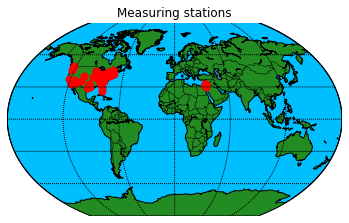

time: 1.43 s (started: 2021-04-18 18:36:03 +00:00)


In [20]:
# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='kav7',lon_0=0,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='forestgreen',lake_color='steelblue')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,360.,60.))
m.drawmapboundary(fill_color='deepskyblue')
m.drawcountries()
lat = np.array(data["city_attributes"]['Latitude'])
lon = np.array(data["city_attributes"]['Longitude'])
m.scatter(lon,lat, s=50,latlon=True, c='red',zorder=2)
plt.title("Measuring stations")
plt.rcParams['figure.figsize'] = [40,10]
plt.show()

## Explore histograms

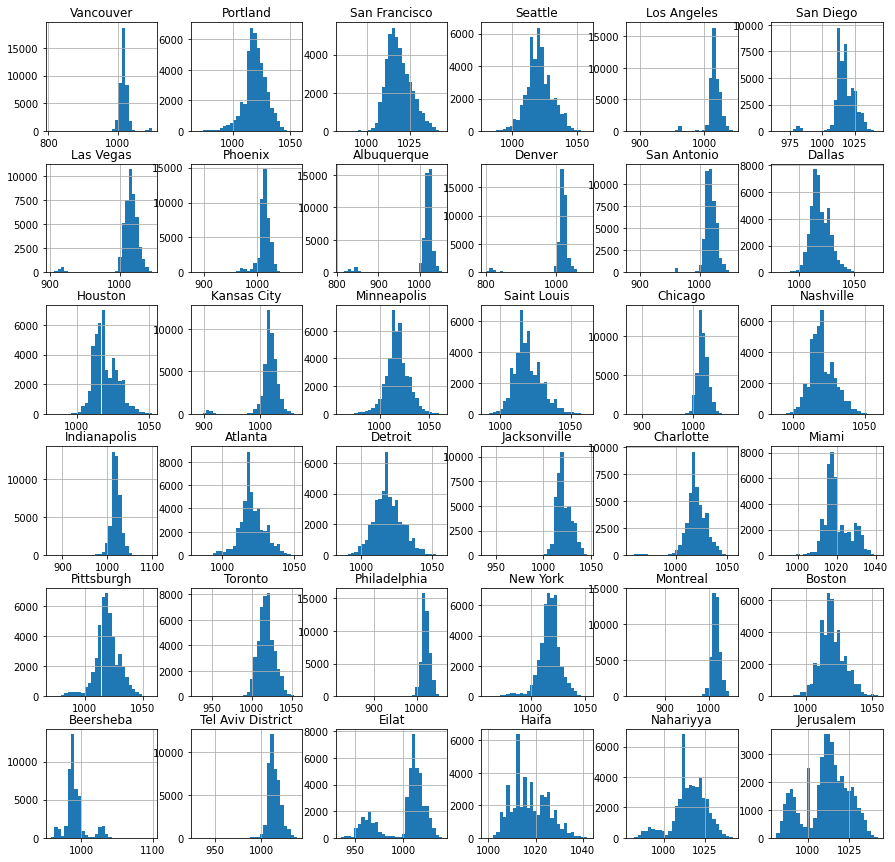

time: 5.98 s (started: 2021-04-18 18:36:05 +00:00)


In [21]:
# Choose with data you would like to explore:
histdata = data["pressure"]
histdata.hist(bins=30, figsize=(15,15))
plt.show()

## Explore time variation

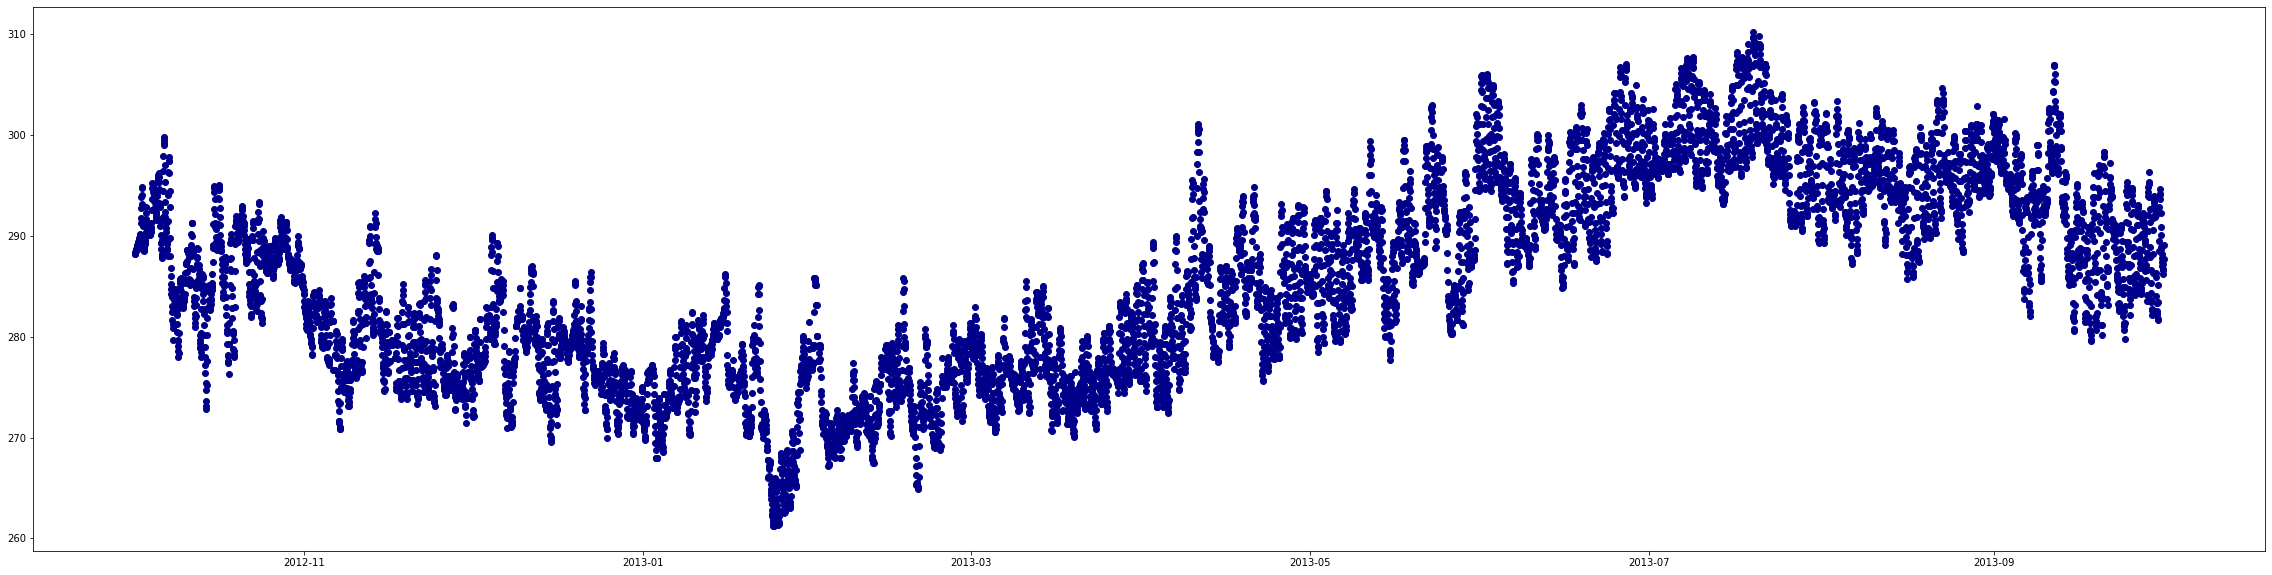

time: 422 ms (started: 2021-04-18 18:36:11 +00:00)


In [22]:
# Choose with data you would like to explore:
timedata = data["temperature"].iloc[0:8761,:]
plt.scatter(x=timedata.index, y=timedata['New York'], c='DarkBlue') #xticks=timedata_tmp.iloc[8760,0]
plt.show()

## Checking for NaN values

In [23]:
# Choose with data you would like to explore:
nandata = data["humidity"]

nandata = nandata.loc[:, 'Vancouver':'Jerusalem']
nanCounter = np.isnan(nandata).sum()
print(nanCounter)
#checkNaN(nandata)

Vancouver            1826
Portland              449
San Francisco         942
Seattle               289
Los Angeles           152
San Diego             344
Las Vegas             842
Phoenix              1308
Albuquerque           710
Denver               1808
San Antonio           564
Dallas                319
Houston               121
Kansas City           512
Minneapolis           510
Saint Louis          1289
Chicago              1109
Nashville             567
Indianapolis          695
Atlanta               422
Detroit               862
Jacksonville          209
Charlotte             589
Miami                1087
Pittsburgh            522
Toronto               728
Philadelphia          624
New York             1624
Montreal             1696
Boston                449
Beersheba             859
Tel Aviv District    1113
Eilat                 970
Haifa                 818
Nahariyya             817
Jerusalem             906
dtype: int64
time: 12.7 ms (started: 2021-04-18 18:36:11 +00:00)

## Exploring time-related information

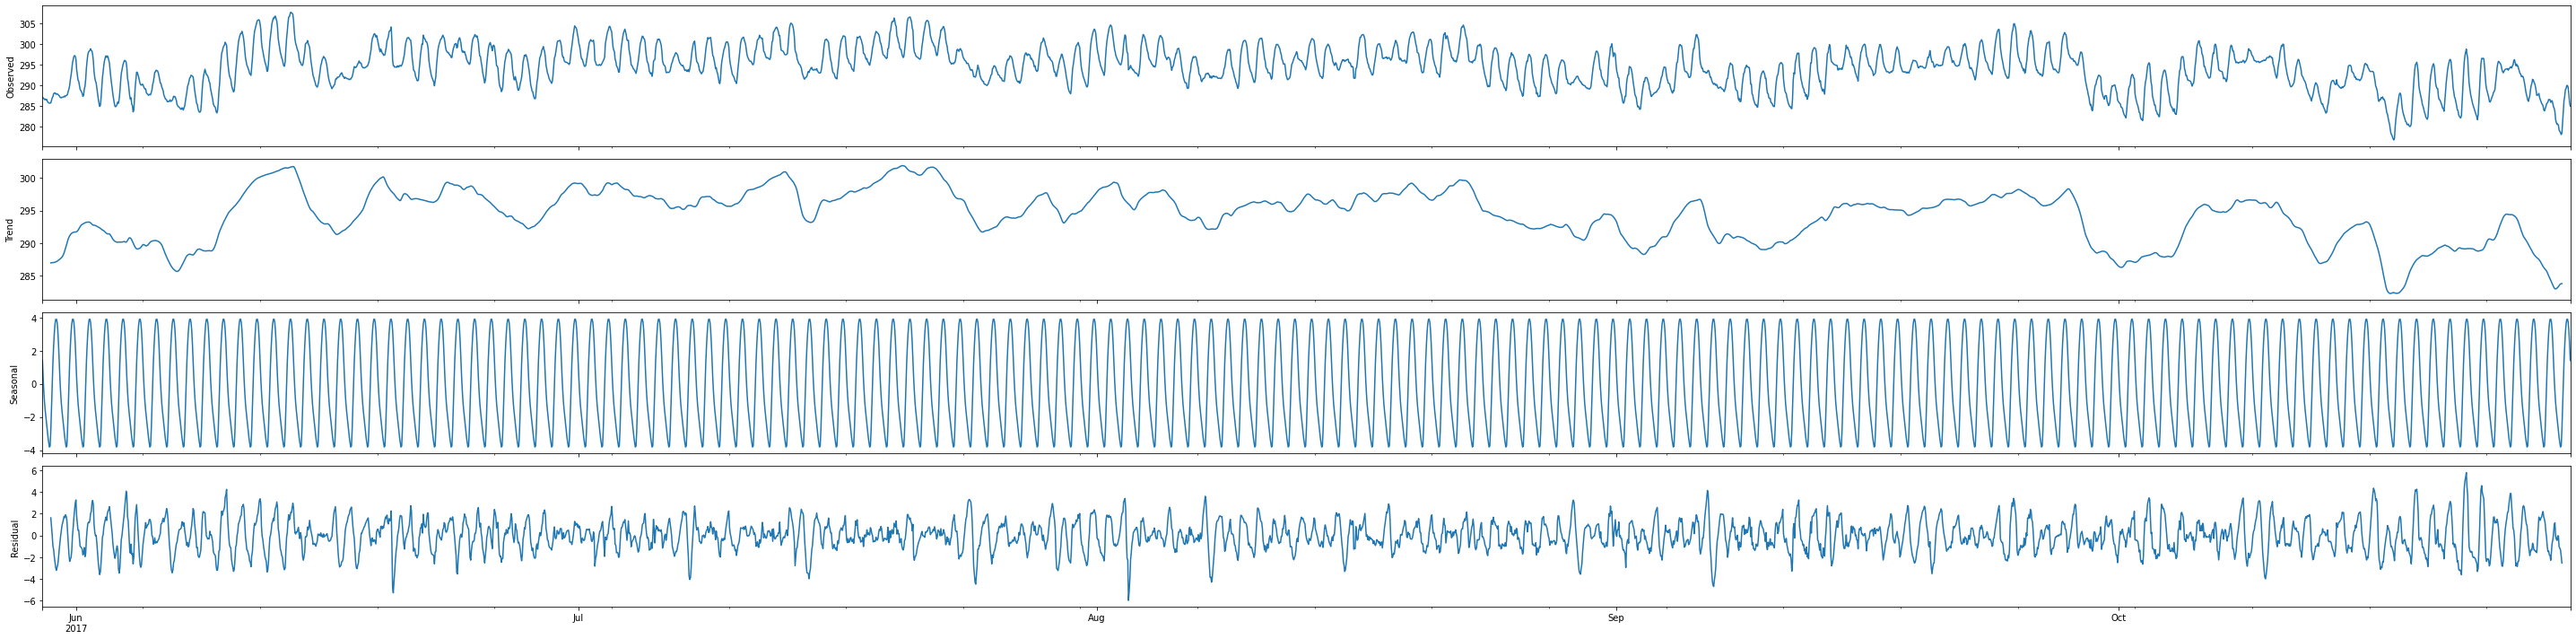

time: 2.09 s (started: 2021-04-18 18:36:11 +00:00)


In [24]:
# Choose with data you would like to explore:
timereldata = data["temperature"]
#taking timereldata column:
data_load = timereldata['New York'].dropna()
#Calling our function:
decomposition = sm.tsa.seasonal_decompose(data_load['2017-05-30':'2017-11-30'], model = 'additive')
#Plotting:
fig = decomposition.plot()
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

# 3. Testing Phase I: Baseline Models

## Logistic Regression - Region Classification

The main task is to predict based on longitude and latitude whether a particular city is located in **North America** or **Israel**. 
The goal is to get familiar with a first simple machine learning algorithm and to test it on simple data.


---



In [25]:
# Adding Region column to data_city_attributes
data_city_attributes_withRegion = data_city_attributes.copy()
data_city_attributes_withRegion["Region"] = 'North America'
data_city_attributes_withRegion.loc[30:35,'Region'] = 'Middle East'

dataX = data_city_attributes_withRegion.copy().drop(['Country','City','Region'],axis=1)
dataYraw = data_city_attributes_withRegion['Region'].copy()

time: 27.8 ms (started: 2021-04-18 18:36:13 +00:00)


In [26]:
#Use LabelEncoder to change label from ('North America', 'Middle East') to (1,0):
transformer = LabelEncoder()
dataYraw2 = transformer.fit_transform(dataYraw)
dataY = pd.Series(dataYraw2)

time: 4.63 ms (started: 2021-04-18 18:36:13 +00:00)


In [27]:
# Count Values of 1 and 0 in label dataset 'dataY'
dataY.value_counts()

1    30
0     6
dtype: int64

time: 15.2 ms (started: 2021-04-18 18:36:13 +00:00)


In [28]:
#Rescaling the 'dataX' data to get mean=0, std=1
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the description again:
dataX.describe()

,Latitude,Longitude
count,3.600000e+01,3.600000e+01
mean,-3.885781e-16,1.233581e-16
std,1.014185e+00,1.014185e+00
min,-1.969329e+00,-9.741446e-01
25%,-7.499977e-01,-6.259846e-01
50%,-1.563108e-01,-2.540078e-01
75%,6.856207e-01,-2.612796e-02
max,2.124616e+00,2.137159e+00


time: 46.2 ms (started: 2021-04-18 18:36:13 +00:00)


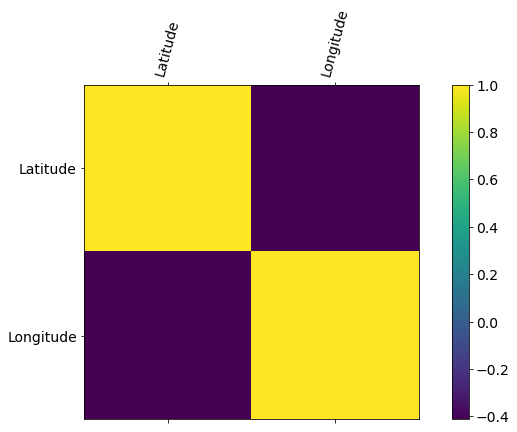

time: 199 ms (started: 2021-04-18 18:36:13 +00:00)


In [29]:
# Calculate and plot correlation matrix
correlationMatrix = pd.DataFrame(dataX).corr() 

f = plt.figure(figsize=(12, 6))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(dataX.shape[1]), dataX.columns, fontsize=14, rotation=75)
plt.yticks(range(dataX.shape[1]), dataX.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

Text(0, 0.5, 'Longitude')

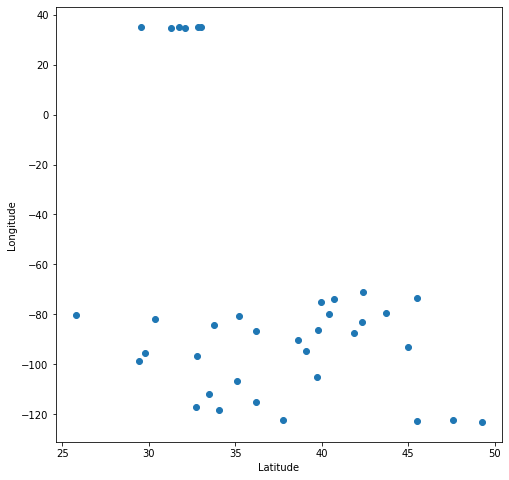

time: 226 ms (started: 2021-04-18 18:36:14 +00:00)


In [30]:
# Retransform to new variable for plotting purpose
dataX_tmp = sX.inverse_transform(dataX[featuresToScale])
# Scatter plot Longitude vs. Latitude
plt.scatter(dataX_tmp[:,0], dataX_tmp[:,1])
plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [31]:
# Split data to train and test set
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.25, random_state=2020, stratify=dataY)

time: 5.73 ms (started: 2021-04-18 18:36:14 +00:00)


In [32]:
# Create cross validation object
k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=2020)

time: 2.12 ms (started: 2021-04-18 18:36:14 +00:00)


In [33]:
# Set Hyperparameters for Logistic Regression model:
penalty       = 'l2'
C             = 1.0 #regularization strength. The smaller the value, the stronger the regularization.
random_state  = 2020
solver        = 'liblinear' # For small datasets, it is good.
# Creat Logistic Regression model object
logReg = LogisticRegression(penalty=penalty, C=C,random_state=random_state, solver=solver)

time: 3.62 ms (started: 2021-04-18 18:36:14 +00:00)


In [34]:
# Model Training:
#-----------------------------------------------------------------------------
#Lists for storing scores
trainingScores = []
cvScores = []

#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

model = logReg

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model according to given data:
  #Note that model refers to logReg.
  model.fit(X_train_fold, y_train_fold)

  # Lets check how good is the fitting. Remember we decided to use log loss.
  # Log loss, aka logistic loss or cross-entropy loss.This is the loss function 
  # used in (multinomial) logistic regression and extensions of it such as neural networks.

  # We will first look log loss in the training dataset. 
  loglossTraining = log_loss(y_train_fold,model.predict_proba(X_train_fold)[:,1])
  #Saving our analysis on the list:
  trainingScores.append(loglossTraining)

  #Lets see how good it is on CV dataset:
  predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)
  loglossCV = log_loss(y_cv_fold,predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
  #Saving our analysis on the list:
  cvScores.append(loglossCV)

  #printing the results:
  print('Training Log Loss: ', loglossTraining)
  print('CV Log Loss: ', loglossCV)

#Lets see the overall log loss for the entire training set (1127)
loglossLogisticRegression = log_loss(y_train,predictionsBasedOnKFolds.loc[:,1])
print('Logistic Regression Log Loss: ', loglossLogisticRegression)

Training Log Loss:  0.12878523208577242
CV Log Loss:  0.1666407407971255
Training Log Loss:  0.13901883016309813
CV Log Loss:  0.1265748486642971
Training Log Loss:  0.13397005954835917
CV Log Loss:  0.15190619640839353
Logistic Regression Log Loss:  0.14837392862327206
time: 63.7 ms (started: 2021-04-18 18:36:14 +00:00)


In [35]:
#See how Logistic Regression performs on test data set:
predictionsTestSetLogisticRegression = pd.DataFrame(data=[],index=y_test.index,columns=[0,1])

predictionsTestSetLogisticRegression.loc[X_test.index,:] = logReg.predict_proba(X_test)
print("0: Probability Middle East")
print("1: Probability North America\n")
print(predictionsTestSetLogisticRegression)

logLossTestSetLogisticRegression = log_loss(y_test, predictionsTestSetLogisticRegression.loc[X_test.index,1])
print('\nLog loss of LogReg model: ', logLossTestSetLogisticRegression)

0: Probability Middle East
1: Probability North America

           0         1
30  0.825494  0.174506
10  0.166395  0.833605
0   0.024548  0.975452
7   0.095848  0.904152
9   0.073622  0.926378
28  0.101545  0.898455
16  0.094601  0.905399
24  0.122893  0.877107
33  0.809022  0.190978

Log loss of LogReg model:  0.12504082657677287
time: 14.1 ms (started: 2021-04-18 18:36:14 +00:00)


In [36]:
# Add predictions to original dataset
predictedRegion = []

probaMiddleEast = lambda i: predictionsTestSetLogisticRegression.iloc[i,0]
probaNorthAmerica = lambda i: predictionsTestSetLogisticRegression.iloc[i,1]

for i in range(len(X_test.index)):
  if probaMiddleEast(i) > probaNorthAmerica(i):
    predictedRegion.append('Middle East')
  else:
    predictedRegion.append('North America')

tablecopy = data_city_attributes_withRegion.iloc[X_test.index,:].copy()
tablecopy["Predicted Region"] = predictedRegion
tablecopy

,City,Country,Latitude,Longitude,Region,Predicted Region
30,Beersheba,Israel,31.251810,34.791302,Middle East,Middle East
10,San Antonio,United States,29.424120,-98.493629,North America,North America
0,Vancouver,Canada,49.249660,-123.119339,North America,North America
7,Phoenix,United States,33.448380,-112.074043,North America,North America
9,Denver,United States,39.739151,-104.984703,North America,North America
28,Montreal,Canada,45.508839,-73.587807,North America,North America
16,Chicago,United States,41.850029,-87.650047,North America,North America
24,Pittsburgh,United States,40.440620,-79.995888,North America,North America
33,Haifa,Israel,32.815559,34.989170,Middle East,Middle East


time: 30.3 ms (started: 2021-04-18 18:36:14 +00:00)


**Conclusion**

Although only a few examples were available, the algorithm shows good predictions. This can be explained by the fact that the longitudes of North America and the Middle East differed strongly from each other, so that a classification is well feasible.

## SARIMAX - Temperatur forecasting

After the first little warm-up exercise, it's now on to predicting the weather, especially predicting the temperature. In the first step, the SARIMAX model is used. SARIMAX stands for:

- S: Seasonal
- AR: Autoregressive
- I: Integrated
- MA: Moving Average
- X: Exogenous factors

If parts like "S" or "X" are not considered, the model simplifies to e.g. the ARIMA model.

---



In [37]:
# Select which city to predict:
city_SX = 'New York'
# Select which feature to predict:
feature_SX = 'temperature'

time: 1.86 ms (started: 2021-04-18 18:36:14 +00:00)


In [38]:
# Combine datasets (*.csv-files) to a single city - dataset
data_SX = get_city_dataset(city_SX)
#data_TA = data_SX
data_SX

,humidity,pressure,temperature,weather_description,wind_direction,wind_speed
2012-10-01 13:00:00,58.0,1012.0,288.220000,few clouds,260.0,7.0
2012-10-01 14:00:00,57.0,1012.0,288.247676,few clouds,260.0,7.0
2012-10-01 15:00:00,57.0,1012.0,288.326940,few clouds,260.0,7.0
2012-10-01 16:00:00,57.0,1012.0,288.406203,few clouds,260.0,7.0
2012-10-01 17:00:00,57.0,1012.0,288.485467,few clouds,261.0,6.0
...,...,...,...,...,...,...
2017-10-27 20:00:00,36.0,1019.0,289.980000,sky is clear,0.0,3.0
2017-10-27 21:00:00,38.0,1019.0,289.480000,sky is clear,0.0,1.0
2017-10-27 22:00:00,54.0,1019.0,287.920000,sky is clear,196.0,2.0
2017-10-27 23:00:00,62.0,1020.0,285.830000,sky is clear,171.0,3.0


time: 49.5 ms (started: 2021-04-18 18:36:14 +00:00)


We have to convert **weather_description** column to numerical values

In [39]:
# Create LabelEncoder object and Encode weather_description values
labelEncoder_SX = LabelEncoder()
data_SX.loc[:,'weather_description'] = labelEncoder_SX.fit_transform(data_SX['weather_description'])

time: 17.1 ms (started: 2021-04-18 18:36:14 +00:00)


Checking for NaN values

In [40]:
checkNaN(data_SX)

humidity               0
pressure               0
temperature            0
weather_description    0
wind_direction         0
wind_speed             0
dtype: int64
time: 7.76 ms (started: 2021-04-18 18:36:14 +00:00)


Start date:  2015-10-29 00:00:00
End date:    2017-10-28 00:00:00


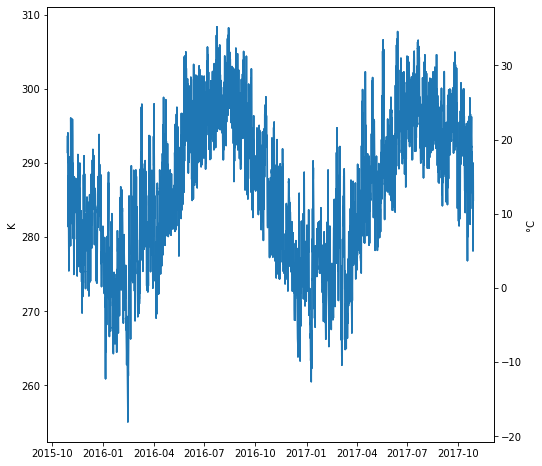

time: 418 ms (started: 2021-04-18 18:36:14 +00:00)


In [41]:
# Plot last 2 years
start_date_SX_2years = data_SX.index[-1].to_pydatetime() - dt.timedelta(days=2 * 365)
end_date_SX_2years = data_SX.index[-1].to_pydatetime()
print("Start date: ", start_date_SX_2years)
print("End date:   ", end_date_SX_2years)
fig, ax1 = plt.subplots()
plt.plot(data_SX[feature_SX][start_date_SX_2years:end_date_SX_2years])
ax1.set_ylabel('K') 
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('°C') 
ax2.plot(data_SX[feature_SX][start_date_SX_2years:end_date_SX_2years]-273.15)

Start date:  2017-10-21 00:00:00
End date:    2017-10-28 00:00:00


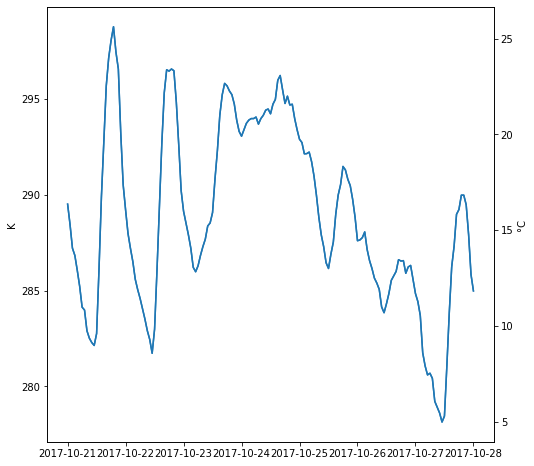

time: 291 ms (started: 2021-04-18 18:36:15 +00:00)


In [42]:
# Plot last week
end_date_SX_1week = data_SX.index[-1].to_pydatetime()
start_date_SX_1week = data_SX.index[-1].to_pydatetime() - dt.timedelta(weeks=1)
print("Start date: ", start_date_SX_1week)
print("End date:   ", end_date_SX_1week)
fig, ax1 = plt.subplots()
plt.plot(data_SX[feature_SX][start_date_SX_1week:end_date_SX_1week])
ax1.set_ylabel('K') 
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('°C') 
ax2.plot(data_SX[feature_SX][start_date_SX_1week:end_date_SX_1week]-273.15)

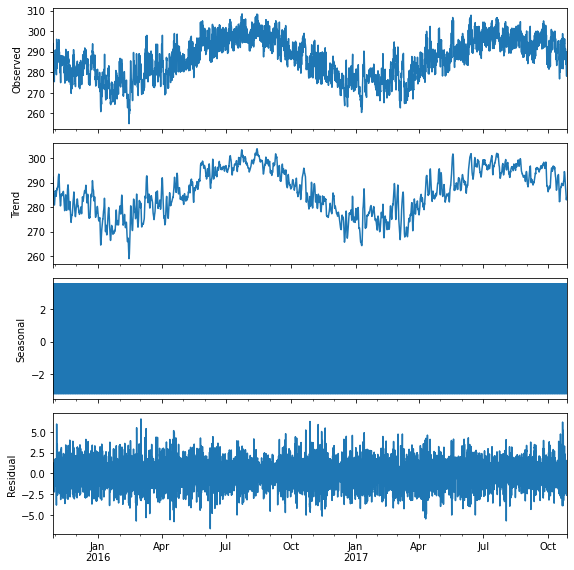

time: 1.96 s (started: 2021-04-18 18:36:15 +00:00)


In [43]:
#Calling our function:
decomposition = sm.tsa.seasonal_decompose(data_SX[feature_SX][start_date_SX_2years:end_date_SX_2years], model = 'additive')
#Plotting:
fig = decomposition.plot()
mpl.rcParams['figure.figsize'] = [16.0, 8.0]

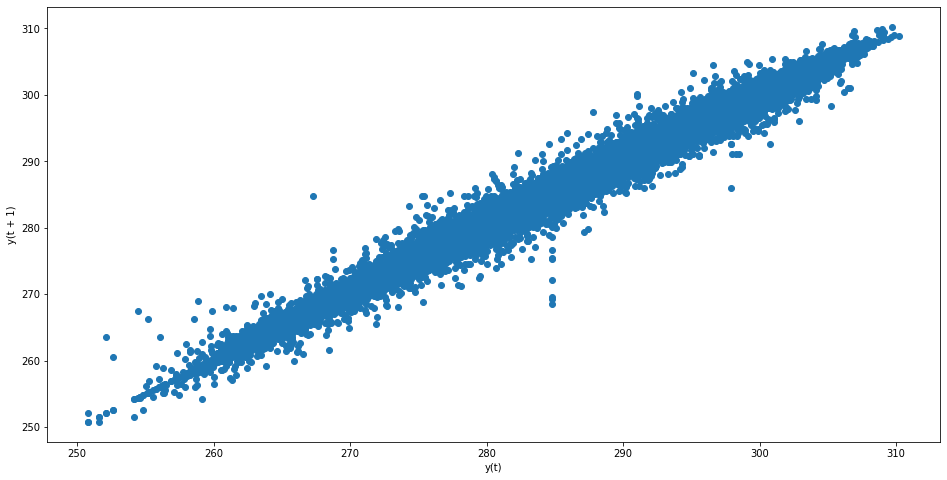

time: 421 ms (started: 2021-04-18 18:36:17 +00:00)


In [44]:
# Plotting the figure:
plt.figure()
lag_plot(data_SX[feature_SX], lag=1)
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

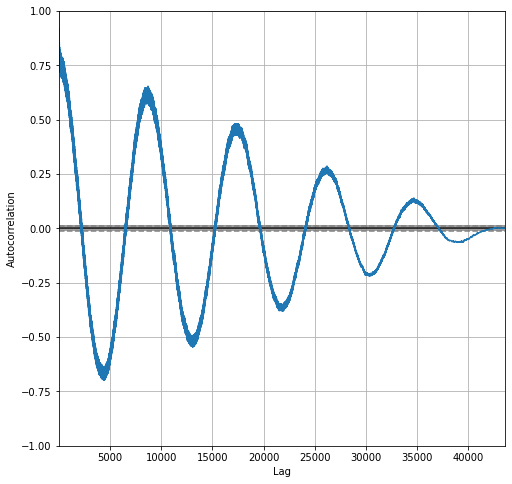

time: 3.21 s (started: 2021-04-18 18:36:17 +00:00)


In [45]:
#Checking autocorrelations:
plt.figure()
autocorrelation_plot(data_SX[feature_SX])
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

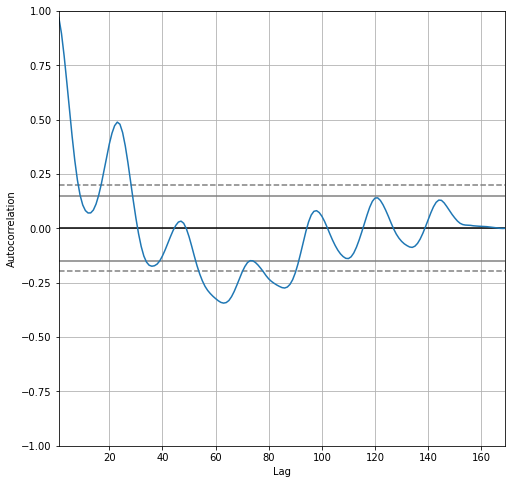

time: 263 ms (started: 2021-04-18 18:36:20 +00:00)


In [46]:
# Autocorrelation last week
data_subset = data_SX[feature_SX][start_date_SX_1week:end_date_SX_1week]
autocorrelation_plot(data_subset)
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

<Figure size 864x432 with 0 Axes>

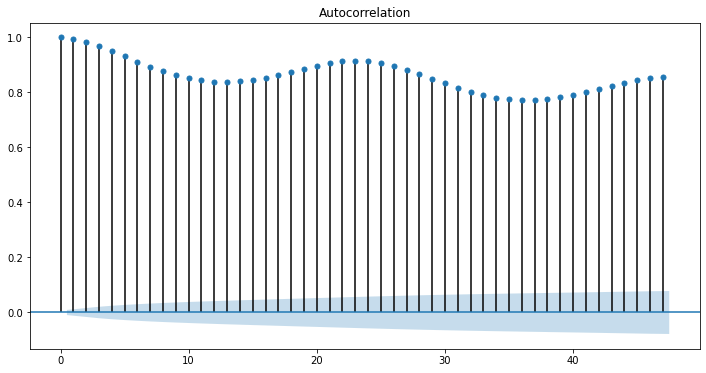

time: 871 ms (started: 2021-04-18 18:36:21 +00:00)


In [47]:
#Another Library.
#Here confidence intervals are drawn as a cone:
plt.figure()
plot_acf(data_SX[feature_SX]);

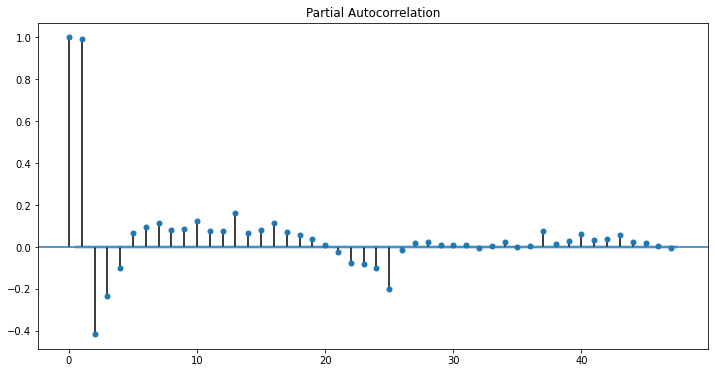

time: 404 ms (started: 2021-04-18 18:36:22 +00:00)


In [48]:
# Partial correlation function
plot_pacf(data_SX[feature_SX])
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

In [49]:
# Check if stationary with Augmented Dickey-Fuller
adf_test = adfuller(data_SX[feature_SX][start_date_SX_2years:end_date_SX_2years])
print("ADF value: ",adf_test[0])
print("p value:    ",  adf_test[1])
print("critical values: ",  adf_test[4])

if adf_test[0] > adf_test[4]["5%"]:
  print("\nData is stationary with more than 95% certainty")
else:
  print("\nData is instationary with more than 95% certainty")

ADF value:  -4.198395564917801
p value:     0.0006630328365039431
critical values:  {'1%': -3.4307242424340445, '5%': -2.861705400687012, '10%': -2.566858038494777}

Data is instationary with more than 95% certainty
time: 1.89 s (started: 2021-04-18 18:36:22 +00:00)


In [50]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2015-10-21'
test_start_dt  = '2017-10-16'
test_end_dt    = '2017-10-19'
# trainin data: filtered copy
train = data_SX.copy()[(data_SX.index >= train_start_dt) & (data_SX.index < test_start_dt)][[feature_SX]]
# test data: filtered copy
test  = data_SX.copy()[(data_SX.index >= test_start_dt ) & (data_SX.index < test_end_dt  )][[feature_SX]]
#let's see how it looks like:
print('Train data shape: ', train.shape)
print('Test data shape: ', test.shape)

Train data shape:  (17424, 1)
Test data shape:  (72, 1)
time: 23.8 ms (started: 2021-04-18 18:36:24 +00:00)


In [51]:
# Adding remaining features as exogenous data
#data_SX_exog = get_city_dataset(city_SX).drop(feature_SX, axis=1)
#train_exog = data_SX_exog.copy()[(data_SX.index >= train_start_dt) & (data_SX.index < test_start_dt)].drop('weather_description', axis=1)
#test_exog  = data_SX_exog.copy()[(data_SX.index >= test_start_dt ) & (data_SX.index < test_end_dt  )].drop('weather_description', axis=1)
#print('Train exog data shape: ', train_exog.shape)
#print('Test exog data shape:  ', test_exog.shape)

time: 5.39 ms (started: 2021-04-18 18:36:24 +00:00)


In [52]:
#Rescaling the data [0,1]
scaler = pp.MinMaxScaler()
train[feature_SX] = scaler.fit_transform(train)
test[feature_SX] = scaler.transform(test)

time: 15.5 ms (started: 2021-04-18 18:36:24 +00:00)


In [53]:
#-----------------------------------------------------------
#Hyperparameters
#-----------------------------------------------------------
horizon = 6
#The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. 
# d must be an integer indicating the integration order of the process, while p and q may either 
# be an integers indicating the AR and MA orders (so that all lags up to those orders are included)
# or else iterables giving specific AR and / or MA lags to include. Default is an AR(1) model: (1,0,0).

order = (3, 1, 6)

#The (P,D,Q,s) order of the seasonal component of the model for:
# the AR parameters,  differences, MA parameters, and periodicity.

seasonal_order = (1, 1, 1, 24)

time: 8.51 ms (started: 2021-04-18 18:36:24 +00:00)


In [54]:
#Copying the test DF:
test_shifted = test.copy()

#preparing the shifted test data:
for t in range(1, horizon):
  test_shifted[feature_SX+'+'+str(t)] = test_shifted[feature_SX].shift(-t) #Original: .shift(-t, freq='H')
test_shifted = test_shifted.dropna()

time: 19 ms (started: 2021-04-18 18:36:24 +00:00)


In [55]:
#Warning update:
#----------------
#each optimization inside the profile likelihood generates a warning, 
#we turn off the warnings here to make the output clean in the below cell:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
#You can check the source code from here:
#https://www.statsmodels.org/0.8.0/_modules/statsmodels/base/model.html

time: 5.22 ms (started: 2021-04-18 18:36:24 +00:00)


In [56]:
# Predictions on test data:
training_window = 720
train_ts = train[feature_SX]
test_ts = test_shifted

history = [x for x in train_ts]

#Filtering the training window: Uncomment the below line if you want.
history = history[(-training_window):]

#Creating predictions to store the model outcomes:
predictions = list()

#Calling model: 
#Horizon calculation list:
print("Ende: ", test_ts.shape[0])
for t in range(0,test_ts.shape[0],horizon):
  model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
  
  #Model fitting:
  model_fit = model.fit()
  
  #Model predictions:
  y_p = model_fit.forecast(steps = horizon)
  obs = list(test_ts.iloc[t])

  # moving the training window: here I add the prediction as in real life we would 
  # not know the true value! Here we will also save the predictions.
  for j in range(horizon):
    predictions.append(y_p[j])
    history.append(y_p[j])
  #Dropping the first horizon elements:
  for j in range(horizon):
    history.pop(0)
  print(test_ts.index[t])
  print(t+1, ': predicted =', y_p, 'true value =', obs)

Ende:  67
2017-10-16 00:00:00
1 : predicted = [0.72743277 0.72815679 0.71924404 0.71015545 0.70637082 0.70041109] true value = [0.7238273921200742, 0.7187617260787986, 0.7187617260787986, 0.7185741088180109, 0.7187617260787986, 0.7187617260787986]
2017-10-16 06:00:00
7 : predicted = [0.69195973 0.68764159 0.68407293 0.68069749 0.67682572 0.67874819] true value = [0.714446529080675, 0.6969981238273926, 0.678424015009381, 0.6534709193245769, 0.6455909943714824, 0.6347091932457776]
2017-10-16 12:00:00
13 : predicted = [0.68536439 0.69579404 0.71529724 0.73176716 0.74799982 0.76486954] true value = [0.6144465290806753, 0.5861163227016881, 0.5831144465290805, 0.5924953095684797, 0.5909943714821759, 0.600375234521576]
2017-10-16 18:00:00
19 : predicted = [0.77724483 0.77985299 0.77721289 0.77354904 0.76091194 0.74435956] true value = [0.5986866791744845, 0.6033771106941836, 0.5924953095684797, 0.5932457786116316, 0.5863039399624759, 0.5711069418386492]
2017-10-17 00:00:00
25 : predicted = [0

In [57]:
# Evaluation of results:
# We will combine the predictions with the actual values in a DF. 
eval_df = pd.DataFrame(predictions)
eval_df.columns = ['prediction']
#Updating the indices:
eval_df=(eval_df.set_index(test.index)) #
#Adding true values:
eval_df['actual'] = test[feature_SX]
#Let's check:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2017-10-16 00:00:00 to 2017-10-18 23:00:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  72 non-null     float64
 1   actual      72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
time: 37.5 ms (started: 2021-04-18 18:51:16 +00:00)


In [58]:
#Back-transforming:
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
print(eval_df)

                     prediction  actual
2017-10-16 00:00:00  293.842166  293.65
2017-10-16 01:00:00  293.880757  293.38
2017-10-16 02:00:00  293.405707  293.38
2017-10-16 03:00:00  292.921285  293.37
2017-10-16 04:00:00  292.719565  293.38
...                         ...     ...
2017-10-18 19:00:00  296.973674  295.31
2017-10-18 20:00:00  296.852085  295.61
2017-10-18 21:00:00  296.672186  294.65
2017-10-18 22:00:00  296.020103  293.00
2017-10-18 23:00:00  295.153591  289.91

[72 rows x 2 columns]
time: 25.4 ms (started: 2021-04-18 18:51:16 +00:00)


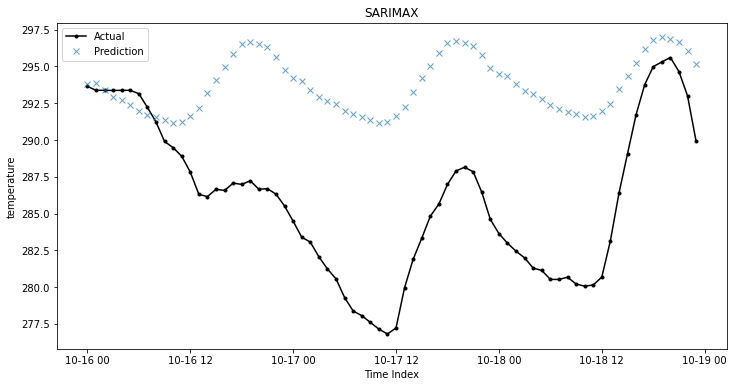

time: 274 ms (started: 2021-04-18 18:51:16 +00:00)


In [59]:
#Plotting predictions: 
plt.figure();
plt.plot(eval_df['actual'], 'k.-');
plt.plot(eval_df['prediction'], 'x', alpha=0.70);
plt.legend(['Actual', 'Prediction'])
plt.ylabel(feature_SX);
plt.xlabel('Time Index');
plt.title('SARIMAX');


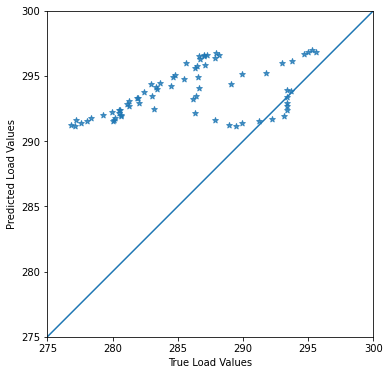

time: 213 ms (started: 2021-04-18 18:51:16 +00:00)


In [60]:
#Visual comparisons of the predictions:
#---------------------------------------
#Visualization of the accuracy
a = plt.axes(aspect='equal')
plt.scatter(eval_df['actual'], eval_df['prediction'],marker='*',alpha=0.80)
plt.xlabel('True Load Values')
plt.ylabel('Predicted Load Values')
lims = [275, 300]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

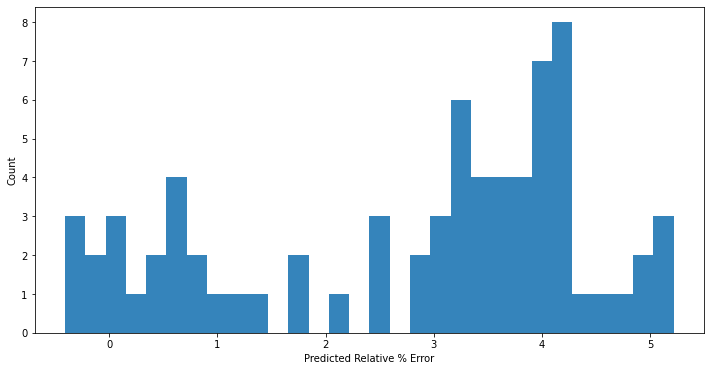

time: 273 ms (started: 2021-04-18 18:51:16 +00:00)


In [61]:
# Calculating the error variations:
error_nn1 = (eval_df['prediction'] - eval_df['actual'])/eval_df['actual']*100

plt.hist(error_nn1, bins=30,alpha=0.9)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [62]:
#Calculating R^2: r2_score(y_true, y_pred)
Score_sarimax = r2_score(eval_df['actual'],eval_df['prediction'])
print('R^2 score is  %3.2f' %np.mean(Score_sarimax))

R^2 score is  -2.05
time: 4.25 ms (started: 2021-04-18 18:51:17 +00:00)


**Conclusion**

Even with different combinations of parameters p,d and q the predictions within this test period don't improve. Nevertheless, it can be seen that the time response is detected in a smooth progression.

## SVM - Temperature forecasting

To obtain better results for time series analysis forecast, Support Vector Machine (SVM) model is used.

In [63]:
# Feature and city to predict:

feature_SVM  = 'temperature'
feature_SVM2 = 'pressure' # Second variable to use in calculation
city_SVM     = 'New York'

time: 2.11 ms (started: 2021-04-18 18:51:17 +00:00)


In [64]:
# Get dataset for 'city_SVM' 
data_SVM = get_city_dataset(city_SVM)
data_SVM

,humidity,pressure,temperature,weather_description,wind_direction,wind_speed
2012-10-01 13:00:00,58.0,1012.0,288.220000,few clouds,260.0,7.0
2012-10-01 14:00:00,57.0,1012.0,288.247676,few clouds,260.0,7.0
2012-10-01 15:00:00,57.0,1012.0,288.326940,few clouds,260.0,7.0
2012-10-01 16:00:00,57.0,1012.0,288.406203,few clouds,260.0,7.0
2012-10-01 17:00:00,57.0,1012.0,288.485467,few clouds,261.0,6.0
...,...,...,...,...,...,...
2017-10-27 20:00:00,36.0,1019.0,289.980000,sky is clear,0.0,3.0
2017-10-27 21:00:00,38.0,1019.0,289.480000,sky is clear,0.0,1.0
2017-10-27 22:00:00,54.0,1019.0,287.920000,sky is clear,196.0,2.0
2017-10-27 23:00:00,62.0,1020.0,285.830000,sky is clear,171.0,3.0


time: 46.3 ms (started: 2021-04-18 18:51:17 +00:00)


In [65]:
#Adding statistics features in dataframes:
#------------------------------------------------
#Let's use only the load data;
temperature_data = data_SVM[feature_SVM]
#Defining the window width:
width = 4
#Calling Rolling:
window = temperature_data.rolling(window=width)
#Let's save as a new DF. We will add min, mean and max to the load column:
new_dataframe = pd.concat([window.median(), window.std(),data_SVM[feature_SVM2], temperature_data], axis=1)
new_dataframe.columns = ['median', 'std',feature_SVM2, feature_SVM]
new_dataframe = new_dataframe.dropna() 
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43606 entries, 2012-10-01 16:00:00 to 2017-10-28 00:00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   median       43606 non-null  float64
 1   std          43606 non-null  float64
 2   pressure     43606 non-null  float64
 3   temperature  43606 non-null  float64
dtypes: float64(4)
memory usage: 1.7 MB
time: 44.3 ms (started: 2021-04-18 18:51:17 +00:00)


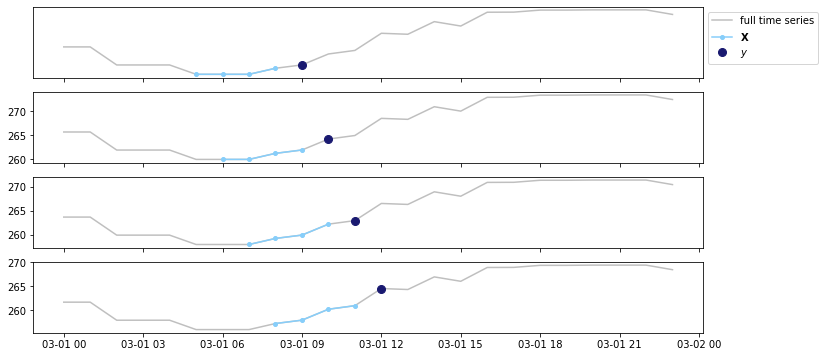

time: 1.03 s (started: 2021-04-18 18:51:17 +00:00)


In [66]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2015-03-01 00:00:00')[0][0]
middle = np.where(new_dataframe.index == '2015-03-01 12:00:00')[0][0]
end = np.where(new_dataframe.index == '2015-03-02 00:00:00')[0][0]
#sliding window width:
window = 4
#Plotting a sliding interval sample:
fig, ax = plt.subplots(nrows=4,sharex=True);
for i in range(4): 
    full = new_dataframe.iloc[start:end][feature_SVM]
    train = new_dataframe.iloc[middle - i - window:middle - i ][feature_SVM]
    predict = new_dataframe.iloc[middle - i:middle - i + 1][feature_SVM]

    ax[3-i].plot((full + 2*i),c='grey', alpha=0.5);
    ax[3-i].plot((train + 2*i),c=colors['lightskyblue'], markersize=4,marker='o')
    ax[3-i].plot((predict + 2*i),c=colors['midnightblue'], markersize=8,marker='o', linestyle='')

ax[0].get_yaxis().set_ticks([]);
ax[0].legend(['full time series','$\mathbf{X}$','$y$'],bbox_to_anchor=(1, 1));

In [67]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2015-10-21 00:00:00')[0][0]
end   = np.where(new_dataframe.index == '2017-10-21 00:00:00')[0][0]

#setting windows width:
window = 4
#emply datalist
dataX_SVM = []
dataY_SVM = []
column_names = []
for i in range(start,end-window):

    # Slice a window of features
    #dataX_SVM.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataX_SVM.append((new_dataframe.iloc[i:i+window,:3].to_numpy()).ravel())
    dataY_SVM.append(new_dataframe[feature_SVM].iloc[i+window] )

# Set column name:
for j in range (1,window+1):
      #column_names.append(['median_t_'+str(j),'std_t_'+str(j),feature_SVM2+'_t_'+str(j),feature_SVM+'_t_'+str(j)])
      column_names.append(['median_t_'+str(j),'std_t_'+str(j),feature_SVM2+'_t_'+str(j)])

column_names = itertools.chain(*column_names)
dataX_SVM = pd.DataFrame(np.vstack(dataX_SVM),index=new_dataframe.iloc[start+window:end].index)
dataX_SVM.columns = column_names
dataY_SVM =pd.Series(dataY_SVM,index=new_dataframe.iloc[start+window:end].index)
dataY_SVM.column = ['true_'+feature_SVM]

time: 3.59 s (started: 2021-04-18 18:51:18 +00:00)


In [68]:
#Original DF:
new_dataframe.loc['2017-10-21 00:00:00':'2017-10-24 00:00:00'].head(6)

,median,std,pressure,temperature
2017-10-21 00:00:00,293.185,2.708167,1022.0,289.51
2017-10-21 01:00:00,290.870,2.586366,1022.0,288.45
2017-10-21 02:00:00,288.980,2.137725,1023.0,287.21
2017-10-21 03:00:00,287.830,1.221420,1024.0,286.83
2017-10-21 04:00:00,287.020,1.000850,1024.0,286.05
2017-10-21 05:00:00,286.440,0.886397,1024.0,285.21


time: 22.7 ms (started: 2021-04-18 18:51:22 +00:00)


In [69]:
dataX_SVM.head(2)

,median_t_1,std_t_1,pressure_t_1,median_t_2,std_t_2,pressure_t_2,median_t_3,std_t_3,pressure_t_3,median_t_4,std_t_4,pressure_t_4
2015-10-21 04:00:00,292.38,1.743127,1023.0,290.9,1.869249,1023.0,289.500,1.360475,1023.0,288.835,0.857088,1020.0
2015-10-21 05:00:00,290.90,1.869249,1023.0,289.5,1.360475,1023.0,288.835,0.857088,1020.0,288.400,0.926301,1024.0


time: 28.8 ms (started: 2021-04-18 18:51:22 +00:00)


In [70]:
dataY_SVM.head(2)

2015-10-21 04:00:00    286.88
2015-10-21 05:00:00    286.17
dtype: float64

time: 8.46 ms (started: 2021-04-18 18:51:22 +00:00)


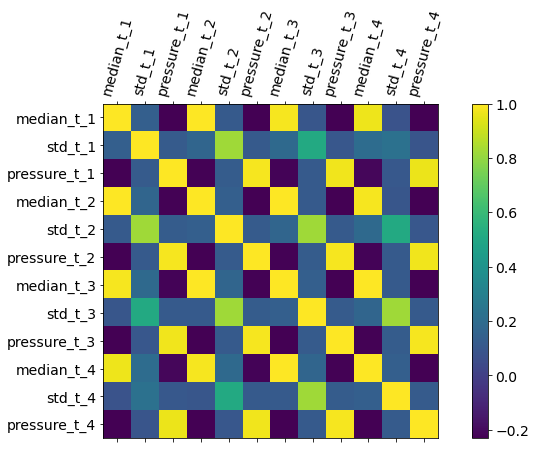

time: 264 ms (started: 2021-04-18 18:51:22 +00:00)


In [71]:
#Correlation Matrix
correlationMatrix = pd.DataFrame(dataX_SVM).corr() 

f = plt.figure(figsize=(12, 6))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(dataX_SVM.shape[1]), dataX_SVM.columns, fontsize=14, rotation=75)
plt.yticks(range(dataX_SVM.shape[1]), dataX_SVM.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [72]:
#Rescaling the data
featuresToScale = dataX_SVM.columns
sX = pp.StandardScaler(copy=True)
dataX_SVM.loc[:,featuresToScale] = sX.fit_transform(dataX_SVM[featuresToScale])
#Looking into the statistics again:
dataX_SVM.describe()

,median_t_1,std_t_1,pressure_t_1,median_t_2,std_t_2,pressure_t_2,median_t_3,std_t_3,pressure_t_3,median_t_4,std_t_4,pressure_t_4
count,1.754000e+04,1.754000e+04,1.754000e+04,1.754000e+04,1.754000e+04,1.754000e+04,1.754000e+04,1.754000e+04,1.754000e+04,1.754000e+04,1.754000e+04,1.754000e+04
mean,-4.127114e-13,-5.047961e-15,-7.376843e-16,-4.159368e-13,-5.100582e-15,-6.577704e-15,-4.158318e-13,-5.100190e-15,5.805571e-15,-4.149993e-13,-5.353568e-15,3.544621e-15
std,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00
min,-3.217279e+00,-1.283603e+00,-3.621777e+00,-3.217246e+00,-1.283577e+00,-3.621791e+00,-3.217203e+00,-1.283514e+00,-3.621802e+00,-3.217158e+00,-1.283500e+00,-3.621814e+00
25%,-7.805774e-01,-7.489315e-01,-5.805924e-01,-7.805848e-01,-7.488815e-01,-5.805770e-01,-7.805975e-01,-7.487934e-01,-5.805556e-01,-7.806159e-01,-7.487730e-01,-5.805459e-01
50%,1.686930e-02,-2.613520e-01,-9.400278e-02,1.684874e-02,-2.612803e-01,-9.398286e-02,1.681796e-02,-2.616790e-01,-9.395614e-02,1.677877e-02,-2.616520e-01,-9.394294e-02
75%,8.311361e-01,4.879880e-01,6.358816e-01,8.311676e-01,4.880593e-01,6.359084e-01,8.313804e-01,4.881818e-01,6.359431e-01,8.315165e-01,4.880185e-01,6.359615e-01
max,2.270933e+00,7.001716e+00,3.677067e+00,2.270876e+00,7.002112e+00,3.677122e+00,2.270794e+00,7.002558e+00,3.677190e+00,2.270696e+00,7.002682e+00,3.677230e+00


time: 84.3 ms (started: 2021-04-18 18:51:22 +00:00)


In [73]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt      = '2015-10-21'
validation_start_dt = '2017-09-17'
test_start_dt       = '2017-09-19'
test_end_dt         = '2017-10-19'
#Let's use the same notation: X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM
X_train_SVM = dataX_SVM.copy()[(dataX_SVM.index >= train_start_dt)& (dataX_SVM.index < test_start_dt)]
y_train_SVM = dataY_SVM.copy()[(dataY_SVM.index >= train_start_dt)& (dataY_SVM.index < test_start_dt)]

X_val_SVM = dataX_SVM.copy()[(dataX_SVM.index >= validation_start_dt)& (dataX_SVM.index < test_start_dt)]
y_val_SVM = dataY_SVM.copy()[(dataY_SVM.index >= validation_start_dt)& (dataY_SVM.index < test_start_dt)]

X_test_SVM =  dataX_SVM.copy()[(dataX_SVM.index >= test_start_dt) & (dataX_SVM.index < test_end_dt)]
y_test_SVM =  dataY_SVM.copy()[(dataY_SVM.index >= test_start_dt) & (dataY_SVM.index < test_end_dt)]


print('Train data shape: ', X_train_SVM.shape, y_train_SVM.shape)
print('Test data shape: ' , X_test_SVM.shape,  y_test_SVM.shape)

Train data shape:  (16772, 12) (16772,)
Test data shape:  (720, 12) (720,)
time: 20.1 ms (started: 2021-04-18 18:51:22 +00:00)


In [74]:
# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)

time: 6.41 ms (started: 2021-04-18 18:51:22 +00:00)


In [75]:
# Model Training:
model = svr
#Fitting the model according to given data:
model.fit(X_train_SVM, y_train_SVM)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=1e-05, verbose=False)

time: 34.6 s (started: 2021-04-18 18:51:22 +00:00)


In [76]:
#Model Predictions:
#------------------
scoreTraining_SVM = model.score(X_train_SVM, y_train_SVM)
print('-----------------------------------')
print('SVM Regression Training R^2 Score: ', scoreTraining_SVM)
print('-----------------------------------')
scoreValidation_SVM = model.score(X_test_SVM, y_test_SVM)
print('-----------------------------------')
print('SVM Regression Validation R^2 Score: ', scoreValidation_SVM)
print('-----------------------------------')

-----------------------------------
SVM Regression Training R^2 Score:  0.9818859714419952
-----------------------------------
-----------------------------------
SVM Regression Validation R^2 Score:  0.9409197838294048
-----------------------------------
time: 3.54 s (started: 2021-04-18 18:51:57 +00:00)


In [77]:
#Visual Comparisons
#------------------
# Let's get the predictions first:
y_predict_SVM = pd.Series(svr.predict(X_test_SVM),index=y_test_SVM.index)

time: 149 ms (started: 2021-04-18 18:52:00 +00:00)


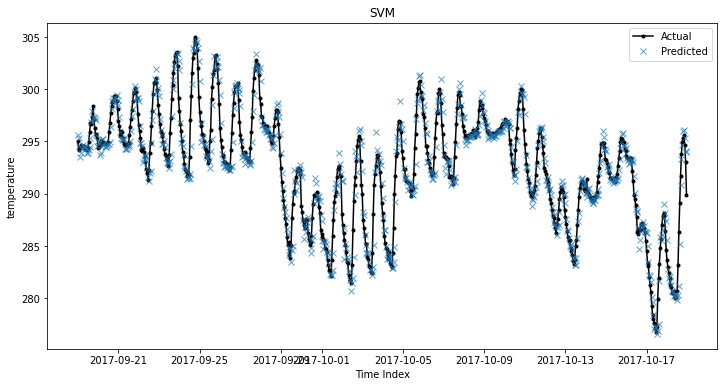

time: 268 ms (started: 2021-04-18 18:52:00 +00:00)


In [78]:
#Plotting the Figure:
plt.figure();
plt.plot(y_test_SVM, 'k.-');
plt.plot(y_predict_SVM, 'x', alpha=0.70);
plt.legend(['Actual', 'Predicted']);
plt.ylabel(feature_SVM);
plt.xlabel('Time Index');
plt.title('SVM');

In [79]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_SVM.index,             y=y_test_SVM.values,             mode='lines+markers', name='Actual'))
fig.add_trace(go.Scatter(x=y_predict_SVM.index, y=y_predict_SVM.values, mode='lines+markers', name='Predicted (SVM)'))
fig.update_xaxes(rangeslider_visible=True)
fig.show()

time: 1.26 s (started: 2021-04-18 18:52:01 +00:00)


**Conclusion**

The SVM model fits the data very good, even for a large time period.

## SVM with PCA - Temperature forecasting

The main task in this section is to optimize forecasting the temperature by combining the Support Vector Machine (SVM) model with Principal Component Analysis (PCA), which is a dimensionality reduction method.

In [80]:
# Feature and city to predict:

feature_SVMPCA  = 'temperature'
feature_SVMPCA2 = 'pressure' # Second variable to use in calculation
city_SVMPCA    = 'New York'

time: 2.19 ms (started: 2021-04-18 18:52:02 +00:00)


In [81]:
# Get dataset for 'city_SVM' 
data_SVMPCA = get_city_dataset(city_SVMPCA)
data_SVMPCA

,humidity,pressure,temperature,weather_description,wind_direction,wind_speed
2012-10-01 13:00:00,58.0,1012.0,288.220000,few clouds,260.0,7.0
2012-10-01 14:00:00,57.0,1012.0,288.247676,few clouds,260.0,7.0
2012-10-01 15:00:00,57.0,1012.0,288.326940,few clouds,260.0,7.0
2012-10-01 16:00:00,57.0,1012.0,288.406203,few clouds,260.0,7.0
2012-10-01 17:00:00,57.0,1012.0,288.485467,few clouds,261.0,6.0
...,...,...,...,...,...,...
2017-10-27 20:00:00,36.0,1019.0,289.980000,sky is clear,0.0,3.0
2017-10-27 21:00:00,38.0,1019.0,289.480000,sky is clear,0.0,1.0
2017-10-27 22:00:00,54.0,1019.0,287.920000,sky is clear,196.0,2.0
2017-10-27 23:00:00,62.0,1020.0,285.830000,sky is clear,171.0,3.0


time: 69.3 ms (started: 2021-04-18 18:52:02 +00:00)


In [82]:
#Adding statistics features in dataframes:
#------------------------------------------------
#Let's use only the load data;
temperature_dataPCA = data_SVMPCA[feature_SVMPCA]
#Defining the window width (larger than normal SVM):
width = 4
#Calling Rolling:
window = temperature_data.rolling(window=width)
#Let's save as a new DF. We will add min, mean and max to the load column:
new_dataframePCA = pd.concat([window.median(), window.std(),data_SVMPCA[feature_SVMPCA2], temperature_dataPCA], axis=1)
new_dataframePCA.columns = ['median', 'std',feature_SVMPCA2, feature_SVMPCA]
new_dataframePCA = new_dataframePCA.dropna() 
new_dataframePCA.info()
new_dataframePCA

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43606 entries, 2012-10-01 16:00:00 to 2017-10-28 00:00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   median       43606 non-null  float64
 1   std          43606 non-null  float64
 2   pressure     43606 non-null  float64
 3   temperature  43606 non-null  float64
dtypes: float64(4)
memory usage: 1.7 MB


,median,std,pressure,temperature
2012-10-01 16:00:00,288.287308,0.083949,1012.0,288.406203
2012-10-01 17:00:00,288.366571,0.102329,1012.0,288.485467
2012-10-01 18:00:00,288.445835,0.102329,1012.0,288.564730
2012-10-01 19:00:00,288.525098,0.102329,1012.0,288.643994
2012-10-01 20:00:00,288.604362,0.102329,1012.0,288.723257
...,...,...,...,...
2017-10-27 20:00:00,289.605000,0.515388,1019.0,289.980000
2017-10-27 21:00:00,289.730000,0.375000,1019.0,289.480000
2017-10-27 22:00:00,289.730000,0.975568,1019.0,287.920000
2017-10-27 23:00:00,288.700000,1.867269,1020.0,285.830000


time: 74.7 ms (started: 2021-04-18 18:52:02 +00:00)


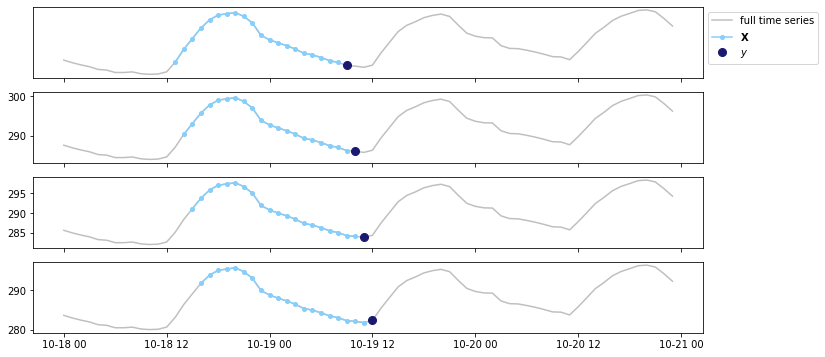

time: 809 ms (started: 2021-04-18 18:52:02 +00:00)


In [83]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframePCA.index == '2017-10-18 00:00:00')[0][0]
middle = np.where(new_dataframePCA.index == '2017-10-19 12:00:00')[0][0]
end = np.where(new_dataframePCA.index == '2017-10-21 00:00:00')[0][0]
#sliding window width:
window = 20
#Plotting a sliding interval sample:
fig, ax = plt.subplots(nrows=4,sharex=True);
for i in range(4): 
    full = new_dataframePCA.iloc[start:end][feature_SVMPCA]
    train = new_dataframePCA.iloc[middle - i - window:middle - i ][feature_SVMPCA]
    predict = new_dataframePCA.iloc[middle - i:middle - i + 1][feature_SVMPCA]

    ax[3-i].plot((full + 2*i),c='grey', alpha=0.5);
    ax[3-i].plot((train + 2*i),c=colors['lightskyblue'], markersize=4,marker='o')
    ax[3-i].plot((predict + 2*i),c=colors['midnightblue'], markersize=8,marker='o', linestyle='')

ax[0].get_yaxis().set_ticks([]);
ax[0].legend(['full time series','$\mathbf{X}$','$y$'],bbox_to_anchor=(1, 1));

In [84]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframePCA.index == '2015-10-21 00:00:00')[0][0]
end = np.where(new_dataframePCA.index == '2017-10-21 00:00:00')[0][0]

#setting windows width:
window = 20
#emply datalist
dataX_SVMPCA = []
dataY_SVMPCA = []
column_names = []
for i in range(start,end-window):

    # Slice a window of features
    #dataX_SVMPCA.append((new_dataframePCA.iloc[i:i+window].to_numpy()).ravel())
    dataX_SVMPCA.append((new_dataframePCA.iloc[i:i+window,:3].to_numpy()).ravel())
    dataY_SVMPCA.append(new_dataframePCA[feature_SVMPCA].iloc[i+window] )

for j in range (1,window+1):
      #column_names.append(['median_t_'+str(j),'std_t_'+str(j),feature_SVMPCA2+'_t_'+str(j),feature_SVMPCA+'_t_'+str(j)])
      column_names.append(['median_t_'+str(j),'std_t_'+str(j),feature_SVMPCA2+'_t_'+str(j)])

column_names = itertools.chain(*column_names)
dataX_SVMPCA = pd.DataFrame(np.vstack(dataX_SVMPCA),index=new_dataframePCA.iloc[start+window:end].index)
dataX_SVMPCA.columns = column_names
dataY_SVMPCA =pd.Series(dataY_SVMPCA,index=new_dataframePCA.iloc[start+window:end].index)
dataY_SVMPCA.column = ['true_'+feature_SVMPCA]

time: 3.88 s (started: 2021-04-18 18:52:03 +00:00)


In [85]:
#Original DF:
new_dataframePCA.loc['2017-10-21 00:00:00':'2017-10-24 00:00:00'].head(6)

,median,std,pressure,temperature
2017-10-21 00:00:00,293.185,2.708167,1022.0,289.51
2017-10-21 01:00:00,290.870,2.586366,1022.0,288.45
2017-10-21 02:00:00,288.980,2.137725,1023.0,287.21
2017-10-21 03:00:00,287.830,1.221420,1024.0,286.83
2017-10-21 04:00:00,287.020,1.000850,1024.0,286.05
2017-10-21 05:00:00,286.440,0.886397,1024.0,285.21


time: 24.7 ms (started: 2021-04-18 18:52:07 +00:00)


In [86]:
dataX_SVMPCA.head(2)

,median_t_1,std_t_1,pressure_t_1,median_t_2,std_t_2,pressure_t_2,median_t_3,std_t_3,pressure_t_3,median_t_4,std_t_4,pressure_t_4,median_t_5,std_t_5,pressure_t_5,median_t_6,std_t_6,pressure_t_6,median_t_7,std_t_7,pressure_t_7,median_t_8,std_t_8,pressure_t_8,median_t_9,std_t_9,pressure_t_9,median_t_10,std_t_10,pressure_t_10,median_t_11,std_t_11,pressure_t_11,median_t_12,std_t_12,pressure_t_12,median_t_13,std_t_13,pressure_t_13,median_t_14,std_t_14,pressure_t_14,median_t_15,std_t_15,pressure_t_15,median_t_16,std_t_16,pressure_t_16,median_t_17,std_t_17,pressure_t_17,median_t_18,std_t_18,pressure_t_18,median_t_19,std_t_19,pressure_t_19,median_t_20,std_t_20,pressure_t_20
2015-10-21 20:00:00,292.38,1.743127,1023.0,290.9,1.869249,1023.0,289.500,1.360475,1023.0,288.835,0.857088,1020.0,288.400,0.926301,1024.0,287.455,1.210248,1024.0,286.525,1.053834,1024.0,285.875,0.716147,1025.0,285.415,0.543714,1025.0,285.07,0.560914,1025.0,284.58,0.754431,1025.0,283.90,0.866771,1026.0,283.39,0.581858,1026.0,283.390,0.808826,1027.0,284.005,1.915037,1027.0,285.935,3.206040,1027.0,288.86,3.666182,1026.0,291.82,3.218380,1026.0,293.75,2.295677,1025.0,295.240,1.573941,1024.0
2015-10-21 21:00:00,290.90,1.869249,1023.0,289.5,1.360475,1023.0,288.835,0.857088,1020.0,288.400,0.926301,1024.0,287.455,1.210248,1024.0,286.525,1.053834,1024.0,285.875,0.716147,1025.0,285.415,0.543714,1025.0,285.070,0.560914,1025.0,284.58,0.754431,1025.0,283.90,0.866771,1026.0,283.39,0.581858,1026.0,283.39,0.808826,1027.0,284.005,1.915037,1027.0,285.935,3.206040,1027.0,288.860,3.666182,1026.0,291.82,3.218380,1026.0,293.75,2.295677,1025.0,295.24,1.573941,1024.0,296.215,0.944705,1024.0


time: 105 ms (started: 2021-04-18 18:52:07 +00:00)


In [87]:
dataY_SVMPCA.head(2)

2015-10-21 20:00:00    296.42
2015-10-21 21:00:00    295.88
dtype: float64

time: 7.72 ms (started: 2021-04-18 18:52:07 +00:00)


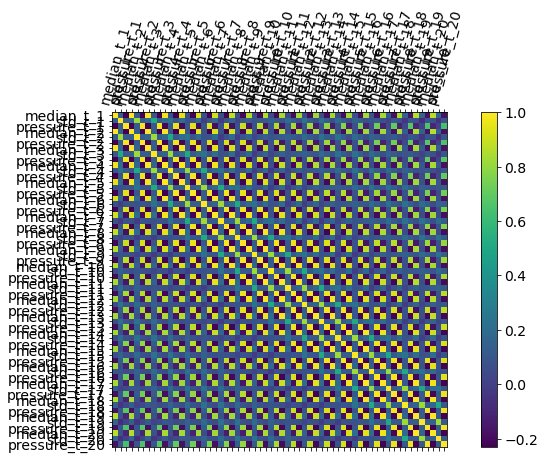

time: 1.5 s (started: 2021-04-18 18:52:07 +00:00)


In [88]:
#Correlation Matrix
correlationMatrixPCA = pd.DataFrame(dataX_SVMPCA).corr() 

f = plt.figure(figsize=(12, 6))
plt.matshow(correlationMatrixPCA, fignum=f.number)
plt.xticks(range(dataX_SVMPCA.shape[1]), dataX_SVMPCA.columns, fontsize=14, rotation=75)
plt.yticks(range(dataX_SVMPCA.shape[1]), dataX_SVMPCA.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [89]:
#Rescaling the data
featuresToScale = dataX_SVMPCA.columns
sX = pp.StandardScaler(copy=True)
dataX_SVMPCA.loc[:,featuresToScale] = sX.fit_transform(dataX_SVMPCA[featuresToScale])
#Looking into the statistics again:
dataX_SVMPCA.describe()

,median_t_1,std_t_1,pressure_t_1,median_t_2,std_t_2,pressure_t_2,median_t_3,std_t_3,pressure_t_3,median_t_4,std_t_4,pressure_t_4,median_t_5,std_t_5,pressure_t_5,median_t_6,std_t_6,pressure_t_6,median_t_7,std_t_7,pressure_t_7,median_t_8,std_t_8,pressure_t_8,median_t_9,std_t_9,pressure_t_9,median_t_10,std_t_10,pressure_t_10,median_t_11,std_t_11,pressure_t_11,median_t_12,std_t_12,pressure_t_12,median_t_13,std_t_13,pressure_t_13,median_t_14,std_t_14,pressure_t_14,median_t_15,std_t_15,pressure_t_15,median_t_16,std_t_16,pressure_t_16,median_t_17,std_t_17,pressure_t_17,median_t_18,std_t_18,pressure_t_18,median_t_19,std_t_19,pressure_t_19,median_t_20,std_t_20,pressure_t_20
count,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04,1.752400e+04
mean,-4.103550e-13,-5.439972e-15,-3.087230e-15,-4.090999e-13,-5.290595e-15,-6.261884e-15,-4.045441e-13,-5.257429e-15,2.634534e-15,-4.043824e-13,-5.306200e-15,-6.601183e-16,-3.993780e-13,-5.707360e-15,2.189139e-15,-3.975058e-13,-5.586562e-15,7.558906e-15,-4.026306e-13,-5.129108e-15,2.376425e-15,-4.010748e-13,-5.202330e-15,-2.511408e-15,-4.039742e-13,-5.144047e-15,-6.760516e-15,-4.017853e-13,-5.283080e-15,-3.353635e-15,-4.109680e-13,-5.231644e-15,6.198471e-16,-4.024087e-13,-5.341108e-15,-3.015525e-15,-4.046074e-13,-5.276790e-15,-5.003720e-15,-4.113256e-13,-5.314195e-15,4.841026e-15,-4.053545e-13,-5.131607e-15,-2.089914e-15,-4.051920e-13,-4.863105e-15,-3.217024e-15,-4.038757e-13,-5.186051e-15,-2.939905e-15,-4.081039e-13,-4.920586e-15,-4.834481e-15,-4.069543e-13,-4.895492e-15,-4.050931e-15,-4.119669e-13,-4.696269e-15,-1.143161e-15
std,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00
min,-3.215881e+00,-1.283442e+00,-3.620047e+00,-3.215890e+00,-1.283451e+00,-3.620059e+00,-3.215887e+00,-1.283466e+00,-3.620070e+00,-3.215879e+00,-1.283398e+00,-3.620082e+00,-3.215871e+00,-1.283346e+00,-3.620080e+00,-3.215860e+00,-1.283313e+00,-3.620103e+00,-3.215848e+00,-1.283276e+00,-3.620127e+00,-3.215836e+00,-1.283231e+00,-3.620151e+00,-3.215824e+00,-1.283213e+00,-3.620187e+00,-3.215816e+00,-1.283248e+00,-3.620218e+00,-3.215817e+00,-1.283285e+00,-3.620250e+00,-3.215833e+00,-1.283153e+00,-3.620274e+00,-3.215862e+00,-1.283051e+00,-3.620323e+00,-3.215894e+00,-1.283034e+00,-3.620371e+00,-3.215917e+00,-1.283044e+00,-3.620444e+00,-3.215921e+00,-1.283063e+00,-3.620518e+00,-3.215899e+00,-1.283307e+00,-3.620592e+00,-3.215856e+00,-1.283672e+00,-3.620646e+00,-3.215818e+00,-1.283850e+00,-3.620699e+00,-3.215793e+00,-1.283898e+00,-3.620735e+00
25%,-7.801185e-01,-7.489915e-01,-5.800607e-01,-7.801019e-01,-7.489838e-01

time: 359 ms (started: 2021-04-18 18:52:08 +00:00)


In [90]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2015-10-21'
test_start_dt  = '2017-09-19'
test_end_dt    = '2017-10-19'

#Let's use the same notation: X_train, X_test, y_train, y_test
X_train = dataX_SVMPCA.copy()[(dataX_SVMPCA.index >= train_start_dt)& (dataX_SVMPCA.index < test_start_dt)]
y_train = dataY_SVMPCA.copy()[(dataY_SVMPCA.index >= train_start_dt)& (dataY_SVMPCA.index < test_start_dt)]

X_test =  dataX_SVMPCA.copy()[(dataX_SVMPCA.index >= test_start_dt) & (dataX_SVMPCA.index < test_end_dt)]
y_test =  dataY_SVMPCA.copy()[(dataY_SVMPCA.index >= test_start_dt) & (dataY_SVMPCA.index < test_end_dt)]


print('Train data shape: ', X_train.shape, y_train.shape)
print('Test data shape: ', X_test.shape, y_test.shape)

Train data shape:  (16756, 60) (16756,)
Test data shape:  (720, 60) (720,)
time: 34.2 ms (started: 2021-04-18 18:52:09 +00:00)


Using **PCA** to reduce dimensions

In [91]:
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
#-----------------
# Hyperparameters:
#-----------------
# if n_components is not set all components are kept: n_components == min(n_samples, n_features)
n_components = 11 # See explained_variance_ration further down
# Whitening will remove some information from the transformed signal
# but can sometime improve the predictive accuracy of the downstream estimators. 
whiten = False #Default option
#If auto, the solver is selected by a default policy based on X.shape and n_components:
svd_solver = 'auto'
#Random state for reproducibility:
random_state = 2020

pca = PCA(n_components=n_components, whiten=whiten, svd_solver = svd_solver, random_state=random_state)

time: 5.52 ms (started: 2021-04-18 18:52:09 +00:00)


In [92]:
# Model Implementation:

#Fit the model with X and apply the dimensionality reduction on X
X_train_PCA = pca.fit_transform(X_train)
# Organizing the data:
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

#Transform data back to its original space:
X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
# Organizing the data:
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, index=X_train.index)


time: 243 ms (started: 2021-04-18 18:52:09 +00:00)


In [93]:
# Variance ratio explained by each of the selected components
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)
# Calculate how much dimensions are required to get a minimum of 95% Variance
explained_variance_ratio_cumsum = list(explained_variance_ratio.cumsum())
elementPCA = [i for i in explained_variance_ratio_cumsum if i >= 0.95][0]
indexPCA = explained_variance_ratio_cumsum.index(elementPCA)
print("################")
print("Minimum Dimensions: ", indexPCA+1) # +1 because Index starts counting at 0
print("################")

[0.37090347 0.25156591 0.07127941 0.05629287 0.05361428 0.04751132
 0.03352385 0.02610605 0.02078938 0.014092   0.00904152]
################
Minimum Dimensions:  11
################
time: 19 ms (started: 2021-04-18 18:52:09 +00:00)


In [94]:
X_train_PCA.sample(2)

,0,1,2,3,4,5,6,7,8,9,10
2016-02-05 02:00:00,-0.170010,2.801224,-2.772889,0.830188,-0.461248,0.814877,-0.850862,-1.076737,0.455470,-0.230952,-0.461496
2016-11-19 14:00:00,0.040599,0.085705,3.339337,0.262166,0.206734,-5.050750,-1.777395,0.304000,-2.725685,1.919804,0.803612


time: 41.6 ms (started: 2021-04-18 18:52:09 +00:00)


In [95]:
# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
#C=1.0 standard value
C=10 #gridsearch
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)

time: 7.87 ms (started: 2021-04-18 18:52:09 +00:00)


In [96]:
# Model Training:
model = svr
#Fitting the model according to given data:
model.fit(X_train_PCA_inverse, y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=1e-05, verbose=False)

time: 5min 58s (started: 2021-04-18 18:52:09 +00:00)


In [97]:
#Model Predictions:
#------------------
scoreTraining = model.score(X_train_PCA_inverse, y_train)
print('-----------------------------------')
print('SVM Regression Training R^2 Score: ', scoreTraining)
print('-----------------------------------')
scoreValidation = model.score(X_test, y_test)
print('-----------------------------------')
print('SVM Regression Validation R^2 Score: ', scoreValidation)
print('-----------------------------------')

-----------------------------------
SVM Regression Training R^2 Score:  0.8955437980381602
-----------------------------------
-----------------------------------
SVM Regression Validation R^2 Score:  0.7372149627302145
-----------------------------------
time: 19.7 s (started: 2021-04-18 18:58:08 +00:00)


In [98]:
#Visual Comparisons
#------------------
# Let's get the predictions first:
y_predictPCA = pd.Series(model.predict(X_test),index=y_test.index)

time: 827 ms (started: 2021-04-18 18:58:28 +00:00)


In [99]:
y_predictPCA

2017-09-19 00:00:00    294.740297
2017-09-19 01:00:00    294.637095
2017-09-19 02:00:00    294.778480
2017-09-19 03:00:00    294.878050
2017-09-19 04:00:00    294.647089
                          ...    
2017-10-18 19:00:00    294.506025
2017-10-18 20:00:00    294.301644
2017-10-18 21:00:00    293.139637
2017-10-18 22:00:00    291.494842
2017-10-18 23:00:00    290.616313
Length: 720, dtype: float64

time: 9.05 ms (started: 2021-04-18 18:58:29 +00:00)


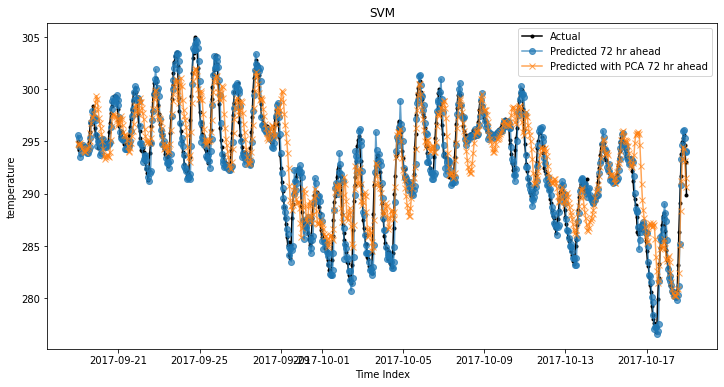

time: 294 ms (started: 2021-04-18 18:58:29 +00:00)


In [100]:
#Plotting the Figure:
plt.figure();
plt.plot(y_test_SVM, 'k.-');
plt.plot(y_predict_SVM, 'o-', alpha=0.70);
plt.plot(y_predictPCA, 'x-', alpha=0.70);
plt.legend(['Actual', 'Predicted 72 hr ahead', 'Predicted with PCA 72 hr ahead']);
plt.ylabel(feature_SVM);
plt.xlabel('Time Index');
plt.title('SVM');

In [101]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_SVM.index,    y=y_test_SVM.values,    mode='lines+markers', name='Actual'))
fig.add_trace(go.Scatter(x=y_predict_SVM.index, y=y_predict_SVM.values, mode='lines+markers', name='Predicted (SVM)'))
fig.add_trace(go.Scatter(x=y_predictPCA.index,  y=y_predictPCA.values,  mode='lines+markers', name='Predicted (SVM with PCA)'))
fig.update_xaxes(rangeslider_visible=True)
fig.show()

time: 270 ms (started: 2021-04-18 18:58:29 +00:00)


## Grid search for SVM with PCA

In [102]:
param_grid = [{
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1.0, 10]
}]

time: 2.28 ms (started: 2021-04-18 18:58:29 +00:00)


In [103]:
# Implementation of gridsearch for SVM with PCA model. To activate change bool_runGridsearch to 'true'.
bool_runGridsearch = False

if bool_runGridsearch:
  grid_search = GridSearchCV(model, param_grid, cv=3)
  grid_search.fit(X_train_PCA_inverse, y_train)
  print(grid_search.best_params_)

# output: {'C': 10, 'kernel': 'rbf'} 

time: 3.53 ms (started: 2021-04-18 18:58:29 +00:00)


## LightGBM - Weather description forecasting with all features

In [104]:
# City used for predictions:

city_LGB = 'New York'

time: 1.11 ms (started: 2021-04-18 18:58:29 +00:00)


In [105]:
# Combine *.csv files to one single dataset
data_LGB = get_city_dataset(city_LGB)
# shift column 'weather_description' to last column
shift_column_last_position(data_LGB,'weather_description')
#data_ANN.loc['2017-09-19']

time: 24.9 ms (started: 2021-04-18 18:58:29 +00:00)




---


Methods to avoid unbalanced data:


1.   Deleting categories with small number of samples
2.   (Adding class weights)
3.   RandomUnderSampler() 

    Ref.: https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html#


---





In [106]:
# Delete rows with labels with less than 100 counts
dd = data_LGB['weather_description'].value_counts()
drop_weather_description_list = dd[7:].keys()
filter = data_LGB['weather_description'].isin(drop_weather_description_list)
loss_of_information_LGB = filter.value_counts()[1]/filter.value_counts()[0]*100
print("Loss of information: %.2f" % loss_of_information_LGB + "%\n")
data_LGB = data_LGB[~filter]
print('Dominant labels: \n')
print(data_LGB['weather_description'].value_counts())
# Used for heatmap plotting (further down)
xy_labels = data_LGB['weather_description'].value_counts().keys()


Loss of information: 12.11%

Dominant labels: 

sky is clear        11341
broken clouds        6142
mist                 5399
scattered clouds     4485
overcast clouds      4316
light rain           3947
few clouds           3267
Name: weather_description, dtype: int64
time: 54 ms (started: 2021-04-18 18:58:29 +00:00)


In [107]:
# Adding class weights to balance data (used in loss function)
class_weights = class_weight.compute_class_weight('balanced', np.unique(data_LGB['weather_description']), data_LGB['weather_description'])
class_weights_LGB = dict(enumerate(class_weights))
class_weights_LGB

{0: 0.9047076336232963,
 1: 1.7008614281341554,
 2: 1.4078323500669587,
 3: 1.0292117587913105,
 4: 1.2874685555408447,
 5: 1.2389552476508998,
 6: 0.48996687115018833}

time: 67.8 ms (started: 2021-04-18 18:58:29 +00:00)


In [108]:
# Transform the dataset using RandomUnderSampler()
data_LGB_RUS = data_LGB.copy()
undersample = RandomUnderSampler(sampling_strategy='all', return_indices=True, random_state=0)
X, y, id_rus  = undersample.fit_resample(data_LGB_RUS.iloc[:,:5], data_LGB.iloc[:,5])
index_rus = data_LGB_RUS.index[id_rus]

pd_X = pd.DataFrame(data=X, index=index_rus, columns= data_LGB_RUS.columns[:5])
pd_y = pd.DataFrame(data=y, index=index_rus, columns=[data_LGB_RUS.columns[5]])
data_LGB = pd.concat([pd_X, pd_y], axis=1)
data_LGB = data_LGB.sort_index()
print(pd_y.value_counts())


weather_description
sky is clear           3267
scattered clouds       3267
overcast clouds        3267
mist                   3267
light rain             3267
few clouds             3267
broken clouds          3267
dtype: int64
time: 156 ms (started: 2021-04-18 18:58:29 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [109]:
data_LGB

,humidity,pressure,temperature,wind_direction,wind_speed,weather_description
2012-10-01 13:00:00,58.0,1012.0,288.220000,260.0,7.0,few clouds
2012-10-01 14:00:00,57.0,1012.0,288.247676,260.0,7.0,few clouds
2012-10-01 15:00:00,57.0,1012.0,288.326940,260.0,7.0,few clouds
2012-10-01 16:00:00,57.0,1012.0,288.406203,260.0,7.0,few clouds
2012-10-01 17:00:00,57.0,1012.0,288.485467,261.0,6.0,few clouds
...,...,...,...,...,...,...
2017-10-27 10:00:00,57.0,1018.0,278.600000,260.0,2.0,sky is clear
2017-10-27 11:00:00,57.0,1018.0,278.130000,290.0,2.0,sky is clear
2017-10-27 13:00:00,57.0,1020.0,281.060000,0.0,2.0,sky is clear
2017-10-27 15:00:00,50.0,1020.0,286.230000,0.0,2.0,sky is clear


time: 29.6 ms (started: 2021-04-18 18:58:30 +00:00)


In [110]:
#finding the indices as integers for time substraction below:
start = np.where(data_LGB.index == data_LGB.index[0])[0][0] # Describes an index
end = np.where(data_LGB.index == data_LGB.index[-1])[0][0]   # Describes an index

#setting windows width:
window = 4

dataX_LGB = []
dataY_LGB = []
column_names = []

for i in range(start,end-window):
    
    # Slice a window of features
    dataX_LGB.append((data_LGB.iloc[i:i+window,:5].to_numpy()).ravel())
    #dataX_LGB.append((data_LGB.iloc[i:i+window,:].to_numpy()).ravel())
    dataY_LGB.append((data_LGB.iloc[i+window,5:35].to_numpy()).ravel())
    
# Set column name:
for j in range (1,window+1):
      column_names.append(['humidity_'+str(j),'pressure_'+str(j),'temperature_'+str(j),'wind_direction'+str(j), 'wind_speed'+str(j)])
      #column_names.append(['humidity_'+str(j),'pressure_'+str(j),'temperature_'+str(j),'wind_direction_'+str(j), 'wind_speed_'+str(j), 'weather_description'+str(j)])
column_names = itertools.chain(*column_names)
dataX_LGB = pd.DataFrame(np.vstack(dataX_LGB),index=data_LGB.iloc[start+window:end].index)
dataX_LGB.columns = column_names
dataY_LGB = pd.DataFrame(np.vstack(dataY_LGB),index=data_LGB.iloc[start+window:end].index, columns=['weather_description'])

time: 16 s (started: 2021-04-18 18:58:30 +00:00)


In [111]:
# Transform label to categorical dtype
dataY_LGB['weather_description'] = pd.Series(dataY_LGB['weather_description'], dtype="category")
#dataY_LGB.dtypes

time: 6.26 ms (started: 2021-04-18 18:58:46 +00:00)


In [112]:
#Rescaling the data (mean=0, std=1)
featuresToScale_LGB = dataX_LGB.columns
sX = pp.StandardScaler(copy=True)
dataX_LGB.loc[:,featuresToScale_LGB] = sX.fit_transform(dataX_LGB[featuresToScale_LGB])
#Looking into the statistics again:
dataX_LGB.describe()

,humidity_1,pressure_1,temperature_1,wind_direction1,wind_speed1,humidity_2,pressure_2,temperature_2,wind_direction2,wind_speed2,humidity_3,pressure_3,temperature_3,wind_direction3,wind_speed3,humidity_4,pressure_4,temperature_4,wind_direction4,wind_speed4
count,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04
mean,5.485295e-16,6.382756e-16,-3.497720e-13,-6.785452e-16,-2.573062e-15,2.915161e-16,-4.980453e-16,-3.397389e-13,-6.859842e-16,-5.055972e-16,2.934293e-16,-6.313931e-15,-3.420112e-13,-3.131194e-16,-1.160354e-15,2.854949e-16,-2.220174e-15,-3.358490e-13,-9.282288e-17,-7.537999e-16
std,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00
min,-2.788025e+00,-5.903546e+00,-3.439491e+00,-1.832775e+00,-1.489823e+00,-2.788020e+00,-5.903607e+00,-3.439419e+00,-1.832775e+00,-1.489802e+00,-2.788020e+00,-5.903668e+00,-3.439340e+00,-1.832770e+00,-1.489780e+00,-2.788020e+00,-5.903728e+00,-3.439299e+00,-1.832544e+00,-1.489759e+00
25%,-7.667131e-01,-5.227060e-01,-7.865132e-01,-8.510844e-01,-5.951742e-01,-7.667102e-01,-5.227357e-01,-7.864646e-01,-8.510844e-01,-5.951068e-01,-7.667102e-01,-5.227654e-01,-7.864128e-01,-8.510889e-01,-5.950394e-01,-7.667102e-01,-5.228031e-01,-7.863792e-01,-8.509268e-01,-5.949721e-01
50%,4.181155e-02,-1.507960e-02,4.822304e-02,2.100759e-01,-1.478495e-01,4.181372e-02,-1.510633e-02,4.823615e-02,2.100759e-01,-1.477593e-01,4.181372e-02,-1.513306e-02,4.827939e-02,2.100618e-01,-1.476690e-01,4.181372e-02,-1.516864e-02,4.831067e-02,2.054799e-01,-1.475787e-01
75%,7.998034e-01,5.940721e-01,8.221409e-01,8.598613e-01,2.994751e-01,7.998049e-01,5.940489e-01,8.221752e-01,8.598613e-01,2.995882e-01,7.998049e-01,5.940258e-01,8.222105e-01,8.598413e-01,2.997014e-01,7.998049e-01,5.939927e-01,8.222397e-01,8.598912e-01,2.998146e-01
max,1.759926e+00,3.538305e+00,2.320538e+00,1.533020e+00,9.693292e+00,1.759927e+00,3.538299e+00,2.320559e+00,1.533020e+00,9.693886e+00,1.759927e+00,3.538293e+00,2.320579e+00,1.532994e+00,9.694480e+00,1.759927e+00,3.538272e+00,2.320604e+00,1.533000e+00,9.695074e+00


time: 133 ms (started: 2021-04-18 18:58:46 +00:00)


In [113]:
# Train-Validation-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt_LGB      = '2013-10-21'
validation_start_dt_LGB = '2016-09-17'
test_start_dt_LGB       = '2016-09-19'
test_end_dt_LGB         = '2017-10-19'

#Let's use the same notation: 
X_train_LGB = dataX_LGB.copy()[(dataX_LGB.index >= train_start_dt_LGB) & (dataX_LGB.index < validation_start_dt_LGB)]
y_train_LGB = dataY_LGB.copy()[(dataY_LGB.index >= train_start_dt_LGB) & (dataY_LGB.index < validation_start_dt_LGB)]

X_val_LGB = dataX_LGB.copy()[(dataX_LGB.index >= validation_start_dt_LGB) & (dataX_LGB.index < test_start_dt_LGB)]
y_val_LGB = dataY_LGB.copy()[(dataY_LGB.index >= validation_start_dt_LGB) & (dataY_LGB.index < test_start_dt_LGB)]

X_test_LGB =  dataX_LGB.copy()[(dataX_LGB.index >= test_start_dt_LGB) & (dataX_LGB.index < test_end_dt_LGB)]
y_test_LGB =  dataY_LGB.copy()[(dataY_LGB.index >= test_start_dt_LGB) & (dataY_LGB.index < test_end_dt_LGB)]

print('Train data shape: ', X_train_LGB.shape, y_train_LGB.shape)
print('Validation data shape: ', X_val_LGB.shape, y_val_LGB.shape)
print('Test data shape: ', X_test_LGB.shape, y_test_LGB.shape)

Train data shape:  (13595, 20) (13595, 1)
Validation data shape:  (31, 20) (31, 1)
Test data shape:  (4583, 20) (4583, 1)
time: 31 ms (started: 2021-04-18 18:58:46 +00:00)


In [114]:
# Hyperparameters for LightGBM model:
# You need to check model descriptions for the hyperparameters. 
# https://lightgbm.readthedocs.io/en/latest/Parameters.html#parameters-format
# Additional: https://neptune.ai/blog/lightgbm-parameters-guide

params_LGB = {
'task':                        'predict',
#'application':                'binary',
'num_class':                         7,
'boosting':                     'gbdt', # traditional Gradient Boosting Decision Tree
'objective':              'multiclass',
'metric':              '', # means to select the metric corresponding to 'objective' #our initial selection
'class_weight': list(class_weights_LGB.values()),
'metric_freq':                       1, # default = 1, type = int, aliases: output_freq, constraints: metric_freq > 0
'training_metric':               False, # set this to true to output metric result over training dataset
'max_depth':                         8, # limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
'num_leaves':                       180, # default = 31, type = int, constraints: 1 < num_leaves <= 131072  # we should let it be smaller than 2^(max_depth)
#'min_data_in_leaf':                 100,
#'max_bin':                          300,
#'lambda_l1':                         50,
#'num_iterations':                     10,
'is_unbalance':                      True,
'learning_rate':                  0.1, # default = 0.1  constraints: learning_rate > 0.0
#'feature_fraction':                0.8, # default = 1.0. #LightGBM will randomly select part of features on each iteration (tree) if feature_fraction smaller than 1.0. For example, if you set it to 0.8, LightGBM will select 80% of features before training each tree
#can be used to speed up training or  to deal with over-fitting.
'bagging_fraction':                0.8, # default = 1.0. this will randomly select part of data without resampling. can be used to deal with over-fitting. 0.0 < bagging_fraction <= 1.0
'bagging_freq':                      0, # 0 means disable bagging; k means perform bagging at every k iteration
'bagging_seed':                   2020, # random seed for bagging
'verbose':                          -1, # default = 1 controls the level of LightGBM’s verbosity. = 0: Error (Warning), = 1: Info, > 1: Debug  
'num_threads':                       0  # default = 0, # for the best speed, set this to the number of real CPU cores, not the number of threads
                                        # do not set it too large if your dataset is small (for instance, do not use 64 threads for a dataset with 10,000 rows)
}

time: 14.2 ms (started: 2021-04-18 18:58:46 +00:00)


LightGBM is not able to handle one-hot-encoded labels. Therefore we can use integer encoded labels. Source:categorical feature support:
https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#categorical-feature-support

In [115]:
transformer_LGB = LabelEncoder()
y_train_LGB_encoded = transformer_LGB.fit_transform(y_train_LGB.values.ravel())
y_train_LGB = pd.Series(y_train_LGB_encoded, index=y_train_LGB.index)

time: 8.6 ms (started: 2021-04-18 18:58:46 +00:00)


In [116]:
y_train_LGB.value_counts()

5    2099
2    2088
0    2081
1    1969
4    1824
6    1784
3    1750
dtype: int64

time: 10.1 ms (started: 2021-04-18 18:58:46 +00:00)


In [117]:
list(class_weights_LGB.values())

[0.9047076336232963,
 1.7008614281341554,
 1.4078323500669587,
 1.0292117587913105,
 1.2874685555408447,
 1.2389552476508998,
 0.48996687115018833]

time: 6.61 ms (started: 2021-04-18 18:58:46 +00:00)


In [118]:
# Cross validation
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)

time: 1.92 ms (started: 2021-04-18 18:58:46 +00:00)


In [119]:
# Model Training:
#-----------------------------------------------------------------------------
#Lists for storing scores
trainingScores_LGB = []
cvScores_LGB = []

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds_LGB = pd.DataFrame(data=[],index=y_train_LGB.index,columns=['prediction'])

#_______________#
#___Modified:___#
#model not defined here!

#kfold.split will generate indices to split data into training and test set (cv):
for train_index_LGB, cv_index_LGB in k_fold.split(np.zeros(len(X_train_LGB)),y_train_LGB.values.ravel()):
  i=0
  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold_LGB, X_cv_fold_LGB = X_train_LGB.iloc[train_index_LGB,:], X_train_LGB.iloc[cv_index_LGB,:]
  y_train_fold_LGB, y_cv_fold_LGB = y_train_LGB.iloc[train_index_LGB], y_train_LGB.iloc[cv_index_LGB]

  # One-hot-encode the cv datasets
  #X_train_fold_1hot_LGB = add_1hot_data(X_train_fold_LGB)
  #X_cv_fold_1hot_LGB    = add_1hot_data(X_cv_fold_LGB)
  #y_train_fold_1hot_LGB = add_1hot_data(y_train_fold_LGB)
  #y_cv_fold_1hot_LGB    = add_1hot_data(y_cv_fold_LGB)

  #Fitting the model according to given data:
  #_______________#
  #___Modified:___#
  #print(y_train_fold_LGB.shape)
  train_LGB    = LGBMClassifier.Dataset(X_train_fold_LGB, y_train_fold_LGB)
  evaluate_LGB = LGBMClassifier.Dataset(X_cv_fold_LGB, y_cv_fold_LGB, reference = train_LGB)
  #Calling the model for training:
  #print(X_train_fold_LGB.shape)
  GBM = LGBMClassifier.train(params_LGB,train_LGB, num_boost_round = 500, valid_sets = evaluate_LGB, early_stopping_rounds = 150)


  #Lets check how good is the fitting. Remember we decided to use log loss.
  # Log loss, aka logistic loss or cross-entropy loss.This is the loss function 
  # used in (multinomial) logistic regression and extensions of it such as neural networks.
  # We will fisrt look log loss in the training dataset. 
  
  #_______________#
  #___Modified:___#
  loglossTraining_LGB = log_loss(y_train_fold_LGB, GBM.predict(X_train_fold_LGB, num_iteration=GBM.best_iteration))
  
  #Saving our analysis on the list:
  trainingScores_LGB.append(loglossTraining_LGB)
  #_______________#
  #___Modified:___#
  #Lets see how good it is on CV dataset:

  pred_cv_nclasses = GBM.predict(X_cv_fold_LGB, num_iteration=GBM.best_iteration)
  pred_cv = [np.argmax(line) for line in pred_cv_nclasses]
  predictionsBasedOnKFolds_LGB.loc[X_cv_fold_LGB.index,'prediction'] = pred_cv

  loglossCV_LGB = log_loss(y_cv_fold_LGB,pred_cv_nclasses)
  #Saving our analysis on the list:
  cvScores_LGB.append(loglossCV_LGB)

  #printing the results:
  print('Training Log Loss: ', loglossTraining_LGB)
  print('CV Log Loss: ', loglossCV_LGB)



[1]	valid_0's multi_logloss: 1.90561
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's multi_logloss: 1.87562
[3]	valid_0's multi_logloss: 1.85005
[4]	valid_0's multi_logloss: 1.82806
[5]	valid_0's multi_logloss: 1.807
[6]	valid_0's multi_logloss: 1.78957
[7]	valid_0's multi_logloss: 1.77204
[8]	valid_0's multi_logloss: 1.75864
[9]	valid_0's multi_logloss: 1.74507
[10]	valid_0's multi_logloss: 1.73222
[11]	valid_0's multi_logloss: 1.72131
[12]	valid_0's multi_logloss: 1.71159
[13]	valid_0's multi_logloss: 1.70345
[14]	valid_0's multi_logloss: 1.69581
[15]	valid_0's multi_logloss: 1.68812
[16]	valid_0's multi_logloss: 1.68122
[17]	valid_0's multi_logloss: 1.67581
[18]	valid_0's multi_logloss: 1.66958
[19]	valid_0's multi_logloss: 1.66455
[20]	valid_0's multi_logloss: 1.65898
[21]	valid_0's multi_logloss: 1.65522
[22]	valid_0's multi_logloss: 1.65097
[23]	valid_0's multi_logloss: 1.64643
[24]	valid_0's multi_logloss: 1.6425
[25]	valid_0's multi_logloss: 1.63878

In [120]:
X_train_LGB

,humidity_1,pressure_1,temperature_1,wind_direction1,wind_speed1,humidity_2,pressure_2,temperature_2,wind_direction2,wind_speed2,humidity_3,pressure_3,temperature_3,wind_direction3,wind_speed3,humidity_4,pressure_4,temperature_4,wind_direction4,wind_speed4
2013-10-21 00:00:00,1.305131,-1.131858,-0.275738,0.766367,-0.147850,1.709394,0.492523,-0.274080,0.766367,-0.147759,0.597674,0.390973,0.208497,0.570012,-0.147669,0.597674,0.390939,0.208528,0.570080,-0.147579
2013-10-21 09:00:00,1.709394,0.492547,-0.274124,0.766367,-0.147850,0.597674,0.390997,0.208455,0.570029,-0.147759,0.597674,0.390973,0.208497,0.570012,-0.147669,0.900870,0.797046,-0.123693,0.467244,-0.147579
2013-10-21 10:00:00,0.597672,0.391022,0.208415,0.570029,-0.147850,0.597674,0.390997,0.208455,0.570029,-0.147759,0.900870,0.797079,-0.123725,0.467169,-0.147669,1.254600,0.898573,-0.511114,0.439198,-0.147579
2013-10-21 13:00:00,0.597672,0.391022,0.208415,0.570029,-0.147850,0.900870,0.797101,-0.123770,0.467185,-0.147759,1.254600,0.898605,-0.511147,0.439121,-0.147669,1.406198,1.101627,-0.475664,0.467244,-0.147579
2013-10-21 16:00:00,0.900869,0.797123,-0.123812,0.467185,-0.147850,1.254600,0.898627,-0.511196,0.439137,-0.147759,1.406198,1.101658,-0.475697,0.467169,-0.147669,0.243945,-3.264029,-0.501231,0.448547,-0.147579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-16 15:00:00,0.142877,0.898648,0.140117,-0.523854,-0.595174,0.345010,0.797101,0.122366,-0.523854,-0.595107,0.142879,0.898605,0.012697,-0.523862,-0.595039,-0.261383,1.000100,0.603782,-1.832544,-0.594972
2016-09-16 17:00:00,0.345008,0.797123,0.122325,-0.523854,-0.595174,0.142879,0.898627,0.012654,-0.523854,-0.595107,-0.261383,1.000132,0.603752,-1.832770,-0.595039,-0.463514,1.000100,0.762912,-1.271620,-0.147579
2016-09-16 18:00:00,0.142877,0.898648,0.012612,-0.523854,-0.595174,-0.261383,1.000152,0.603715,-1.832775,-0.595107,-0.463514,1.000132,0.762883,-1.271809,-0.147669,-0.463514,1.000100,0.908204,-1.458594,-0.147579
2016-09-16 19:00:00,-0.261385,1.000173,0.603679,-1.832775,-0.595174,-0.463514,1.000152,0.762847,-1.271809,-0.147759,-0.463514,1.000132,0.908175,-1.458796,-0.147669,-0.817243,1.000100,0.966519,-1.178132,0.299815


time: 50.7 ms (started: 2021-04-18 18:59:40 +00:00)


In [121]:
y_test_LGB_encoded = transformer_LGB.fit_transform(y_test_LGB.values.ravel())

time: 3.46 ms (started: 2021-04-18 18:59:40 +00:00)


Confusion Matrix

In [122]:
y_preds_train = GBM.predict(X_train_LGB, num_iteration=GBM.best_iteration)
y_preds_train = [np.argmax(line) for line in y_preds_train]
y_preds_test = GBM.predict(X_test_LGB, num_iteration=GBM.best_iteration)
y_preds_test = [np.argmax(line) for line in y_preds_test]

cm_train = confusion_matrix(y_train_LGB,y_preds_train)
cm_test  = confusion_matrix(y_test_LGB_encoded ,y_preds_test)

time: 1.89 s (started: 2021-04-18 18:59:40 +00:00)


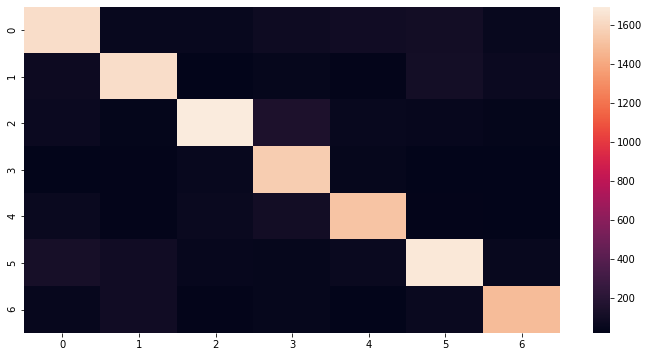

time: 309 ms (started: 2021-04-18 18:59:42 +00:00)


In [123]:
sns_train = sns.heatmap(cm_train, annot=False)

In [124]:
# Calculate percentage of right predicted values
diag = []
for i in range(cm_train.shape[0]):
  diag.append(cm_train[i,i])

right_predicted = np.array(diag).sum()
all = cm_train.sum()
print("Percentage of right predicted values: {:.2f} %" .format(right_predicted/all*100))

Percentage of right predicted values: 82.42 %
time: 4.89 ms (started: 2021-04-18 18:59:42 +00:00)


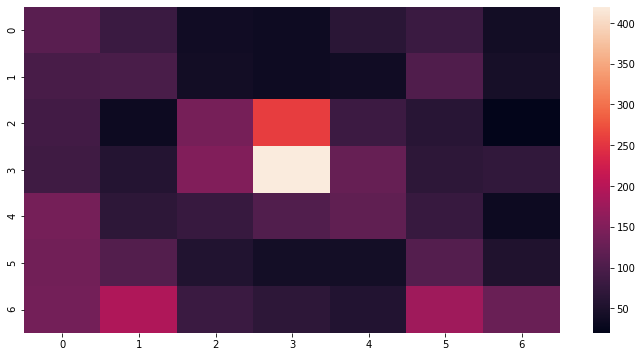

time: 297 ms (started: 2021-04-18 18:59:42 +00:00)


In [125]:
sns_test  = sns.heatmap(cm_test , annot=False)

In [126]:
# Calculate percentage of right predicted values
diag = []
for i in range(cm_test.shape[0]):
  diag.append(cm_test[i,i])

right_predicted = np.array(diag).sum()
all = cm_test.sum()
print("Percentage of right predicted values: {:.2f} %" .format(right_predicted/all*100))

Percentage of right predicted values: 24.59 %
time: 5.35 ms (started: 2021-04-18 18:59:43 +00:00)


**Conclusion**

The LightGBM model fits the training data but the heatmap plot of the confusion matrix seems to indicate overfitting. But trying to regularize the model leads to a drastic decrease in prediction accuracy of the training data.

Overall the model predicting the temperature profile perform well (with exeption of SARIMAX). The LightGBM model for predicting the weather description performs well on the training data but very poor on test data. As we will later see, the neural network will lead to similar results.

# 4. Testing Phase II: Model Development

## NN - Temperature forecasting
The main task will be to develop a neural network which is capable of predicting the temperature profile of a choosen city. Additionally the model will be compared with the baseline models.

In [127]:
# Copy train and test set from SVM model
X_train_NN = X_train_SVM.copy()
y_train_NN = y_train_SVM.copy()
X_test_NN  = X_test_SVM.copy()
y_test_NN  = y_test_SVM.copy()
X_val_NN   = X_val_SVM.copy()
y_val_NN   = y_val_SVM.copy()
print(X_train_NN.shape, X_test_NN.shape)
print(y_train_NN.shape, y_test_NN.shape)

(16772, 12) (720, 12)
(16772,) (720,)
time: 12.5 ms (started: 2021-04-18 18:59:43 +00:00)


In [128]:
def build_model_batch():
  # Here we will use Sequential API
  # He Initialization in combination with ReLU to have a variance of 1
  # LeakyReLU: ReLU with slight gradient (0.1) for negative x values 
  # BatchNormalization(): Scale and shift inputs (batch) before processing to activation function
  # l2 regularization (limit weights)
  model = models.Sequential([
  layers.Dense(30, input_shape=(X_train_NN.shape[1],)),keras.layers.LeakyReLU(alpha=0.1),  
  layers.Dense(30, kernel_initializer="he_normal"),keras.layers.LeakyReLU(alpha=0.1),      
  layers.Dense(15, kernel_initializer="he_normal"),keras.layers.LeakyReLU(alpha=0.1),                            
  layers.Dense(1)
  ])
  
  # Adam Optimizer: Adaptive Moment Estimation: Momentum Optimization + RMSProp
  model.compile(optimizer='Adam', loss=['mse'], metrics=['mae'])
  K.set_value(model.optimizer.learning_rate, 0.001)
  return model


time: 6.6 ms (started: 2021-04-18 18:59:43 +00:00)


In [129]:
#Looking at the graph:
build_model_batch().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                390       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                465       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 15)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [130]:
#We will first create the object to feed fit() method:
myCheckpoint= keras.callbacks.ModelCheckpoint("my_best_model.h5", best_model_only =True)

time: 1.16 ms (started: 2021-04-18 18:59:43 +00:00)


In [131]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

time: 2.04 ms (started: 2021-04-18 18:59:43 +00:00)


In [132]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 10

time: 1.75 ms (started: 2021-04-18 18:59:43 +00:00)


In [133]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_base_NN = build_model_batch()

#Training step: Trains the model in silent mode (verbose = 0)
history_base = model_base_NN.fit(X_train_NN, y_train_NN, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val_NN, y_val_NN) , 
                                callbacks=[myCheckpoint,myEarly_stopping])#, verbose=0)
#Calling back the best model:
model_best = keras.models.load_model("my_best_model.h5")

Epoch 1/100
1678/1678 [==============================] - 4s 2ms/step - loss: 24348.0903 - mae: 115.5903 - val_loss: 125.3820 - val_mae: 8.5931
Epoch 2/100
1678/1678 [==============================] - 2s 1ms/step - loss: 124.7183 - mae: 7.9771 - val_loss: 10.1504 - val_mae: 2.5102
Epoch 3/100
1678/1678 [==============================] - 2s 1ms/step - loss: 9.2742 - mae: 2.1107 - val_loss: 2.0267 - val_mae: 1.2338
Epoch 4/100
1678/1678 [==============================] - 2s 1ms/step - loss: 3.9194 - mae: 1.4019 - val_loss: 2.6104 - val_mae: 1.3068
Epoch 5/100
1678/1678 [==============================] - 2s 1ms/step - loss: 3.4287 - mae: 1.3473 - val_loss: 0.6253 - val_mae: 0.6235
Epoch 6/100
1678/1678 [==============================] - 2s 1ms/step - loss: 3.4188 - mae: 1.3936 - val_loss: 2.2238 - val_mae: 1.3735
Epoch 7/100
1678/1678 [==============================] - 2s 1ms/step - loss: 3.3174 - mae: 1.3755 - val_loss: 3.5133 - val_mae: 1.7512
Epoch 8/100
1678/1678 [=====================

In [134]:
#Let's look into the history recorded:
hist = pd.DataFrame(history_base.history)
hist.sample(3)

,loss,mae,val_loss,val_mae
30,2.380519,1.161517,0.316245,0.458729
12,2.642675,1.227810,0.255192,0.405987
5,3.316336,1.364924,2.223805,1.373547


time: 27.2 ms (started: 2021-04-18 19:01:01 +00:00)


In [135]:
#Adding epoch column:
hist['epoch'] = history_base.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist.sample(3)

,loss,mae,val_loss,val_mae,epoch
1,73.334641,5.799774,10.150401,2.510191,1
30,2.380519,1.161517,0.316245,0.458729,30
6,3.125659,1.328377,3.513271,1.751218,6


time: 19.4 ms (started: 2021-04-18 19:01:01 +00:00)


In [136]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history['epoch'],history['loss'], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'],history['val_loss'], "b-.", linewidth=1.5, label="Validation")
  plt.legend()
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Loss (MSE)")

time: 12.7 ms (started: 2021-04-18 19:01:01 +00:00)


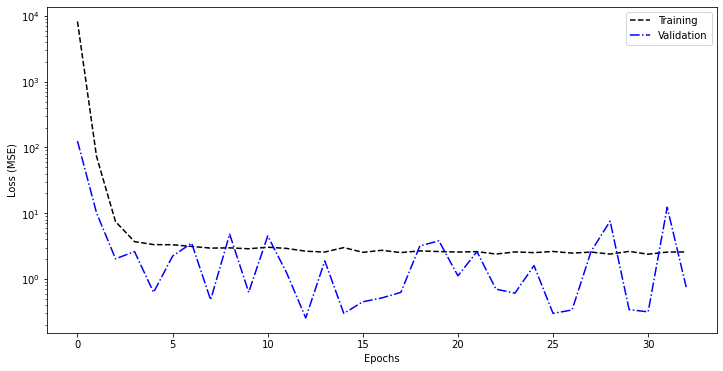

time: 541 ms (started: 2021-04-18 19:01:01 +00:00)


In [137]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist)

The reason why we have less error in validation set might be:

+ Due to the regularization error applied during the training

+ Training loss is measured during each epoch (while it learns) yet the validation loss is calculated at the end of each epoch (after learning)

+ We might be lucky with the validation fraction of the data. It may be a simple portion of the data, compared to noisier training set.

+ How we split the training-test data. Here we use a large history of 2 years including many random events and anormalies. Three days into future might be a just a regular window. To test it, reduce the volume of the training data. You would see that the gap will be closed.

+ There is a mistake in the data preprocessing. Double check the data matrices!

                     median_t_1   std_t_1  ...   std_t_4  pressure_t_4
2017-09-19 00:00:00    1.017204 -0.958697  ... -1.020192      0.271009
2017-09-19 01:00:00    1.017204 -1.211538  ... -0.682423      0.271009
2017-09-19 02:00:00    1.013011 -1.136288  ... -0.297394      0.271009
2017-09-19 03:00:00    1.004625 -1.020322  ... -0.334053      0.271009
2017-09-19 04:00:00    0.984707 -0.682588  ... -0.749963      0.271009
...                         ...       ...  ...       ...           ...
2017-10-18 19:00:00   -0.163147  4.090581  ...  2.504394      1.000914
2017-10-18 20:00:00    0.147665  4.099747  ...  1.090878      1.000914
2017-10-18 21:00:00    0.428077  3.411454  ... -0.094882      0.879263
2017-10-18 22:00:00    0.673896  2.503897  ... -0.678633      0.879263
2017-10-18 23:00:00    0.844764  1.090527  ...  0.423200      0.879263

[720 rows x 12 columns]
2017-09-19 00:00:00    295.998749
2017-09-19 01:00:00    295.721283
2017-09-19 02:00:00    294.992706
2017-09-19 03:00:00  

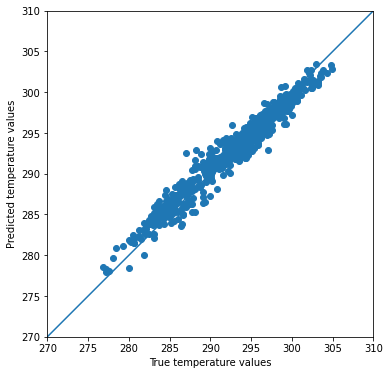

time: 424 ms (started: 2021-04-18 19:01:02 +00:00)


In [138]:
# Calling trained model for predictions:
print(X_test_NN)
Y_test_predictions_NN = pd.Series(model_base_NN.predict(X_test_NN).flatten(),index=X_test_NN.index)
print(Y_test_predictions_NN)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test_NN, Y_test_predictions_NN)
plt.xlabel('True temperature values')
plt.ylabel('Predicted temperature values')
lims = [270, 310]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

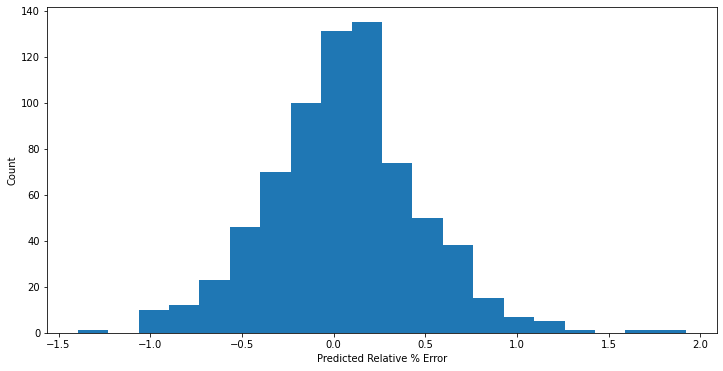

time: 257 ms (started: 2021-04-18 19:01:02 +00:00)


In [139]:
# Calculating the error variations:
error_nn = (Y_test_predictions_NN - y_test_NN)/y_test_NN*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [140]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions_NN - y_test_NN)/y_test_NN*100
np.average(abs_error_nn)

0.31824627932072164

time: 6.94 ms (started: 2021-04-18 19:01:03 +00:00)


In [141]:
#Calculating R2 value:
r2_test = r2_score(y_test_NN, Y_test_predictions_NN)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.95
time: 4.17 ms (started: 2021-04-18 19:01:03 +00:00)


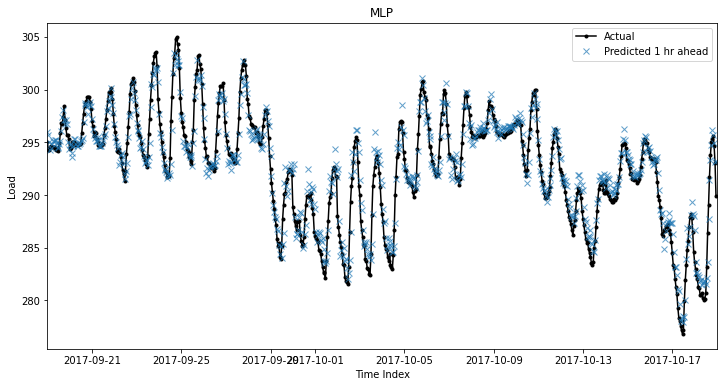

time: 286 ms (started: 2021-04-18 19:01:03 +00:00)


In [142]:
#Plotting the Figure: 
plt.figure();
plt.plot(y_test_NN, 'k.-');
plt.plot(Y_test_predictions_NN, 'x', alpha=0.70);
plt.xlim([dt.datetime.strptime(test_start_dt, '%Y-%m-%d'), dt.datetime.strptime(test_end_dt, '%Y-%m-%d')])
plt.legend(['Actual',
            'Predicted 1 hr ahead'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('MLP');
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

In [143]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_NN.index,             y=y_test_NN.values,             mode='lines+markers', name='Actual'))
fig.add_trace(go.Scatter(x=Y_test_predictions_NN.index, y=Y_test_predictions_NN.values, mode='lines+markers', name='Predicted'))
fig.update_xaxes(rangeslider_visible=True)
fig.show()

time: 244 ms (started: 2021-04-18 19:01:03 +00:00)


**Randomized Search**

In [144]:
def build_model_batch_RS(n_hidden=1,n_neurons=10):
  # Here we will use Sequential API
  # He Initialization in combination with ReLU to have a variance of 1
  # LeakyReLU: ReLU with slight gradient (0.1) for negative x values 
  # BatchNormalization(): Scale and shift inputs (batch) before processing to activation function
  # l2 regularization (limit weights)
  model = models.Sequential()
  model.add(keras.layers.Dense(32, kernel_initializer="he_normal", input_shape=(X_train_NN.shape[1],)))  
  model.add(keras.layers.BatchNormalization())
  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.BatchNormalization())

  model.add(keras.layers.Dense(1))
  
  # Adam Optimizer: Adaptive Moment Estimation: Momentum Optimization + RMSProp
  model.compile(optimizer='Adam', loss=['mse'], metrics=['mae'])
  return model


time: 9.63 ms (started: 2021-04-18 19:01:03 +00:00)


In [145]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model_batch_RS)

time: 1.19 ms (started: 2021-04-18 19:01:03 +00:00)


In [146]:
keras_reg.fit(X_train_NN, y_train_NN, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val_NN, y_val_NN) ,callbacks=[myCheckpoint,myEarly_stopping])

Epoch 1/100
1678/1678 [==============================] - 3s 2ms/step - loss: 77060.6086 - mae: 277.3035 - val_loss: 48728.9883 - val_mae: 220.7433
Epoch 2/100
1678/1678 [==============================] - 2s 1ms/step - loss: 37080.2243 - mae: 190.5514 - val_loss: 9437.4834 - val_mae: 97.1410
Epoch 3/100
1678/1678 [==============================] - 2s 1ms/step - loss: 5267.4073 - mae: 69.1667 - val_loss: 152.2996 - val_mae: 12.2995
Epoch 4/100
1678/1678 [==============================] - 2s 1ms/step - loss: 59.4942 - mae: 6.4018 - val_loss: 0.6870 - val_mae: 0.6916
Epoch 5/100
1678/1678 [==============================] - 2s 1ms/step - loss: 13.8694 - mae: 2.9545 - val_loss: 0.8174 - val_mae: 0.7456
Epoch 6/100
1678/1678 [==============================] - 2s 1ms/step - loss: 13.0387 - mae: 2.8781 - val_loss: 1.4881 - val_mae: 1.0897
Epoch 7/100
1678/1678 [==============================] - 2s 1ms/step - loss: 13.5428 - mae: 2.9319 - val_loss: 1.0159 - val_mae: 0.9192
Epoch 8/100
1678/1678 

time: 1min 23s (started: 2021-04-18 19:01:03 +00:00)


In [147]:
# First try
#param_distribs = {
#    "n_hidden": [0, 1, 2],
#    "n_neurons": [10, 20, 30]
#}

# Second try
param_distribs = {
    "n_hidden": [2, 3, 4],
    "n_neurons": [30, 40, 50]
}

time: 2.43 ms (started: 2021-04-18 19:02:27 +00:00)


In [148]:
# Choose to run RandomSearchCV() by changing bool_runRandomsearch to 'true'
bool_runRandomsearch = False

if bool_runRandomsearch:
  rnd_search_sv = RandomizedSearchCV(keras_reg, param_distributions=param_distribs, n_iter=5)
  rnd_search_sv.fit(X_train_NN, y_train_NN, epochs=num_epochs, validation_data=(X_val_NN, y_val_NN) , callbacks=[myCheckpoint,myEarly_stopping])

time: 2.66 ms (started: 2021-04-18 19:02:27 +00:00)


In [149]:
# rnd_search_sv.best_params_

# output: {'n_hidden': 3, 'n_neurons': 30}

time: 1.93 ms (started: 2021-04-18 19:02:27 +00:00)


## NN - Weather description forecasting with all features
This neural network should be a multiclass classification model for predicting the weather description based on humidity, pressure , wind_speed and wind_direction. It must be mentioned that the existing labels are strongly unbalanced.

Ref.: https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a

In [150]:
# Choose which city to predict:

city_ANN = 'New York'
#city_ANN = 'Vancouver'

time: 1.68 ms (started: 2021-04-18 19:02:27 +00:00)


In [151]:
# Combine *.csv files to one single dataset
data_ANN = get_city_dataset(city_ANN)
# shift column 'weather_description' to last column
shift_column_last_position(data_ANN,'weather_description')
#data_ANN.loc['2017-09-19']

time: 28.6 ms (started: 2021-04-18 19:02:27 +00:00)


In [152]:
# Delete rows with labels with less than 100 counts
dd = data_ANN['weather_description'].value_counts()
drop_weather_description_list = dd[7:].keys()
filter = data_ANN['weather_description'].isin(drop_weather_description_list)
loss_of_information_ANN = filter.value_counts()[1]/filter.value_counts()[0]*100
print("Loss of information: %.2f" % loss_of_information_ANN + "%\n")
data_ANN = data_ANN[~filter]
print(data_ANN['weather_description'].value_counts())
# Used for heatmap plotting (further down)
xy_labels = data_ANN['weather_description'].value_counts().keys()
# Weather description for correlation analysis with flight delay
weather_data_flight_delay = data_ANN['weather_description'].loc['2016-01-01':'2016-12-31'].dropna()
weather_data_flight_delay


Loss of information: 12.11%

sky is clear        11341
broken clouds        6142
mist                 5399
scattered clouds     4485
overcast clouds      4316
light rain           3947
few clouds           3267
Name: weather_description, dtype: int64


2016-01-01 00:00:00      broken clouds
2016-01-01 01:00:00      broken clouds
2016-01-01 02:00:00    overcast clouds
2016-01-01 03:00:00    overcast clouds
2016-01-01 04:00:00      broken clouds
                            ...       
2016-12-31 19:00:00       sky is clear
2016-12-31 20:00:00       sky is clear
2016-12-31 21:00:00    overcast clouds
2016-12-31 22:00:00      broken clouds
2016-12-31 23:00:00      broken clouds
Name: weather_description, Length: 7896, dtype: object

time: 52.4 ms (started: 2021-04-18 19:02:27 +00:00)


In [153]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(data_ANN['weather_description']), data_ANN['weather_description'])
class_weights_ANN = dict(enumerate(class_weights))
class_weights_ANN

{0: 0.9047076336232963,
 1: 1.7008614281341554,
 2: 1.4078323500669587,
 3: 1.0292117587913105,
 4: 1.2874685555408447,
 5: 1.2389552476508998,
 6: 0.48996687115018833}

time: 48.4 ms (started: 2021-04-18 19:02:27 +00:00)


We have to convert **weather_description** column to numerical values

In [154]:
# Transform the dataset using RandomUnderSampler()
data_ANN_RUS = data_ANN.copy()
undersample = RandomUnderSampler(sampling_strategy='all', return_indices=True, random_state=0)
X, y, id_rus  = undersample.fit_resample(data_ANN_RUS.iloc[:,:5], data_ANN.iloc[:,5])
index_rus = data_ANN_RUS.index[id_rus]

pd_X = pd.DataFrame(data=X, index=index_rus, columns= data_ANN_RUS.columns[:5])
pd_y = pd.DataFrame(data=y, index=index_rus, columns=[data_ANN_RUS.columns[5]])
data_ANN = pd.concat([pd_X, pd_y], axis=1)
data_ANN = data_ANN.sort_index()
print(pd_y.value_counts())


weather_description
sky is clear           3267
scattered clouds       3267
overcast clouds        3267
mist                   3267
light rain             3267
few clouds             3267
broken clouds          3267
dtype: int64
time: 154 ms (started: 2021-04-18 19:02:27 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [155]:
data_ANN = add_1hot_data(data_ANN)

time: 10.3 ms (started: 2021-04-18 19:02:27 +00:00)


In [156]:
data_ANN.columns[5:35]
data_ANN.tail(50)

,humidity,pressure,temperature,wind_direction,wind_speed,broken clouds,few clouds,light rain,mist,overcast clouds,scattered clouds,sky is clear
2017-10-23 20:00:00,64.0,1021.0,295.23,140.0,6.0,1,0,0,0,0,0,0
2017-10-23 21:00:00,68.0,1020.0,294.74,140.0,5.0,1,0,0,0,0,0,0
2017-10-23 23:00:00,73.0,1019.0,293.31,140.0,5.0,1,0,0,0,0,0,0
2017-10-24 01:00:00,73.0,1018.0,293.40,150.0,6.0,1,0,0,0,0,0,0
2017-10-24 05:00:00,83.0,1016.0,293.98,160.0,5.0,0,0,1,0,0,0,0
2017-10-24 06:00:00,83.0,1016.0,294.06,158.0,6.0,0,0,0,0,1,0,0
2017-10-24 08:00:00,83.0,1013.0,293.98,167.0,7.0,0,0,1,0,0,0,0
2017-10-24 09:00:00,83.0,1015.0,294.15,167.0,7.0,0,0,0,1,0,0,0
2017-10-24 11:00:00,78.0,1011.0,294.48,190.0,3.0,0,0,1,0,0,0,0
2017-10-24 14:00:00,83.0,1011.0,294.98,0.0,2.0,0,0,1,0,0,0,0


time: 44.4 ms (started: 2021-04-18 19:02:27 +00:00)


In [157]:
#finding the indices as integers for time substraction below:
start = np.where(data_ANN.index == data_ANN.index[0])[0][0] # Describes an index
end = np.where(data_ANN.index == data_ANN.index[-1])[0][0]   # Describes an index

#setting windows width:
window = 4
#emply datalist
dataX_ANN = []
dataY_ANN = []
column_names = []

for i in range(start,end-window):
    
    # Slice a window of features
    dataX_ANN.append((data_ANN.iloc[i:i+window,:5].to_numpy()).ravel())
    #dataX_ANN.append((data_ANN.iloc[i:i+window,:].to_numpy()).ravel())
    #dataY_ANN.append(data_ANN['weather_description'].iloc[i+window] )
    dataY_ANN.append((data_ANN.iloc[i+window,5:35].to_numpy()).ravel())
    #print(dataY_ANN)
# Set column name:
for j in range (1,window+1):
      column_names.append(['humidity_'+str(j),'pressure_'+str(j),'temperature_'+str(j),'wind_direction'+str(j), 'wind_speed'+str(j)])
      #column_names.append(['humidity_'+str(j),'pressure_'+str(j),'temperature_'+str(j),'wind_direction'+str(j), 'wind_speed'+str(j),'1'+str(j),'2'+str(j),'3'+str(j),'4'+str(j),'5'+str(j),'6'+str(j),'7'+str(j)])
column_names = itertools.chain(*column_names)
dataX_ANN = pd.DataFrame(np.vstack(dataX_ANN),index=data_ANN.iloc[start+window:end].index)
dataX_ANN.columns = column_names

dataY_ANN = pd.DataFrame(np.vstack(dataY_ANN),index=data_ANN.iloc[start+window:end].index)
dataY_ANN.columns = data_ANN.columns[5:35]

time: 15.3 s (started: 2021-04-18 19:02:27 +00:00)


In [158]:
#Rescaling the data
featuresToScale_ANN = dataX_ANN.columns
sX = pp.StandardScaler(copy=True)
dataX_ANN.loc[:,featuresToScale_ANN] = sX.fit_transform(dataX_ANN[featuresToScale_ANN])
#Looking into the statistics again:
dataX_ANN.describe()

,humidity_1,pressure_1,temperature_1,wind_direction1,wind_speed1,humidity_2,pressure_2,temperature_2,wind_direction2,wind_speed2,humidity_3,pressure_3,temperature_3,wind_direction3,wind_speed3,humidity_4,pressure_4,temperature_4,wind_direction4,wind_speed4
count,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04,2.286400e+04
mean,5.485295e-16,6.382756e-16,-3.497720e-13,-6.785452e-16,-2.573062e-15,2.915161e-16,-4.980453e-16,-3.397389e-13,-6.859842e-16,-5.055972e-16,2.934293e-16,-6.313931e-15,-3.420112e-13,-3.131194e-16,-1.160354e-15,2.854949e-16,-2.220174e-15,-3.358490e-13,-9.282288e-17,-7.537999e-16
std,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00
min,-2.788025e+00,-5.903546e+00,-3.439491e+00,-1.832775e+00,-1.489823e+00,-2.788020e+00,-5.903607e+00,-3.439419e+00,-1.832775e+00,-1.489802e+00,-2.788020e+00,-5.903668e+00,-3.439340e+00,-1.832770e+00,-1.489780e+00,-2.788020e+00,-5.903728e+00,-3.439299e+00,-1.832544e+00,-1.489759e+00
25%,-7.667131e-01,-5.227060e-01,-7.865132e-01,-8.510844e-01,-5.951742e-01,-7.667102e-01,-5.227357e-01,-7.864646e-01,-8.510844e-01,-5.951068e-01,-7.667102e-01,-5.227654e-01,-7.864128e-01,-8.510889e-01,-5.950394e-01,-7.667102e-01,-5.228031e-01,-7.863792e-01,-8.509268e-01,-5.949721e-01
50%,4.181155e-02,-1.507960e-02,4.822304e-02,2.100759e-01,-1.478495e-01,4.181372e-02,-1.510633e-02,4.823615e-02,2.100759e-01,-1.477593e-01,4.181372e-02,-1.513306e-02,4.827939e-02,2.100618e-01,-1.476690e-01,4.181372e-02,-1.516864e-02,4.831067e-02,2.054799e-01,-1.475787e-01
75%,7.998034e-01,5.940721e-01,8.221409e-01,8.598613e-01,2.994751e-01,7.998049e-01,5.940489e-01,8.221752e-01,8.598613e-01,2.995882e-01,7.998049e-01,5.940258e-01,8.222105e-01,8.598413e-01,2.997014e-01,7.998049e-01,5.939927e-01,8.222397e-01,8.598912e-01,2.998146e-01
max,1.759926e+00,3.538305e+00,2.320538e+00,1.533020e+00,9.693292e+00,1.759927e+00,3.538299e+00,2.320559e+00,1.533020e+00,9.693886e+00,1.759927e+00,3.538293e+00,2.320579e+00,1.532994e+00,9.694480e+00,1.759927e+00,3.538272e+00,2.320604e+00,1.533000e+00,9.695074e+00


time: 133 ms (started: 2021-04-18 19:02:42 +00:00)


In [159]:
# Train-Validation-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt_ANN      = '2013-10-21'
validation_start_dt_ANN = '2016-09-17'
test_start_dt_ANN       = '2016-09-19'
test_end_dt_ANN         = '2017-10-19'

#Let's use the same notation: 
X_train_ANN = dataX_ANN.copy()[(dataX_ANN.index >= train_start_dt_ANN)& (dataX_ANN.index < validation_start_dt_ANN)]
y_train_ANN = dataY_ANN.copy()[(dataY_ANN.index >= train_start_dt_ANN)& (dataY_ANN.index < validation_start_dt_ANN)]

X_val_ANN = dataX_ANN.copy()[(dataX_ANN.index >= validation_start_dt_ANN)& (dataX_ANN.index < test_start_dt_ANN)]
y_val_ANN = dataY_ANN.copy()[(dataY_ANN.index >= validation_start_dt_ANN)& (dataY_ANN.index < test_start_dt_ANN)]

X_test_ANN =  dataX_ANN.copy()[(dataX_ANN.index >= test_start_dt_ANN) & (dataX_ANN.index < test_end_dt_ANN)]
y_test_ANN =  dataY_ANN.copy()[(dataY_ANN.index >= test_start_dt_ANN) & (dataY_ANN.index < test_end_dt_ANN)]

print('Train data shape: ', X_train_ANN.shape, y_train_ANN.shape)
print('Validation data shape: ', X_val_ANN.shape, y_val_ANN.shape)
print('Test data shape: ', X_test_ANN.shape, y_test_ANN.shape)

Train data shape:  (13595, 20) (13595, 7)
Validation data shape:  (31, 20) (31, 7)
Test data shape:  (4583, 20) (4583, 7)
time: 34.4 ms (started: 2021-04-18 19:02:43 +00:00)


In [160]:
X_train_ANN.shape[1]

20

time: 6.45 ms (started: 2021-04-18 19:02:43 +00:00)


In [161]:
def build_model_batch_ANN():
  # Here we will use Sequential API
  # He Initialization in combination with ReLU to have a variance of 1
  # LeakyReLU: ReLU with slight gradient (0.1) for negative x values 
  # BatchNormalization(): Scale and shift inputs (batch) before processing to activation function
  # l2 regularization (limit weights)
  model = models.Sequential([
  layers.Dense(20, input_shape=(X_train_ANN.shape[1],),activation='relu'), keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(15, input_shape=(X_train_ANN.shape[1],),activation='relu'), keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(7, activation='softmax')
  ])
  
  # Adam Optimizer: Adaptive Moment Estimation: Momentum Optimization + RMSProp
  model.compile(optimizer='Adam', loss=['categorical_crossentropy'], metrics=['accuracy'])   #loss=mse metrics=mae
  K.set_value(model.optimizer.learning_rate, 0.001)
  return model


time: 13.5 ms (started: 2021-04-18 19:02:43 +00:00)


In [162]:
#We will first create the object to feed fit() method:
myCheckpoint_ANN = keras.callbacks.ModelCheckpoint("my_best_model_ANN.h5", save_best_only=True)

time: 2.24 ms (started: 2021-04-18 19:02:43 +00:00)


In [163]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping_ANN = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

time: 2.35 ms (started: 2021-04-18 19:02:43 +00:00)


In [164]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs_ANN = 200
batch_size_ANN = 20

time: 2.72 ms (started: 2021-04-18 19:02:43 +00:00)


In [165]:
X_train_ANN

,humidity_1,pressure_1,temperature_1,wind_direction1,wind_speed1,humidity_2,pressure_2,temperature_2,wind_direction2,wind_speed2,humidity_3,pressure_3,temperature_3,wind_direction3,wind_speed3,humidity_4,pressure_4,temperature_4,wind_direction4,wind_speed4
2013-10-21 00:00:00,1.305131,-1.131858,-0.275738,0.766367,-0.147850,1.709394,0.492523,-0.274080,0.766367,-0.147759,0.597674,0.390973,0.208497,0.570012,-0.147669,0.597674,0.390939,0.208528,0.570080,-0.147579
2013-10-21 09:00:00,1.709394,0.492547,-0.274124,0.766367,-0.147850,0.597674,0.390997,0.208455,0.570029,-0.147759,0.597674,0.390973,0.208497,0.570012,-0.147669,0.900870,0.797046,-0.123693,0.467244,-0.147579
2013-10-21 10:00:00,0.597672,0.391022,0.208415,0.570029,-0.147850,0.597674,0.390997,0.208455,0.570029,-0.147759,0.900870,0.797079,-0.123725,0.467169,-0.147669,1.254600,0.898573,-0.511114,0.439198,-0.147579
2013-10-21 13:00:00,0.597672,0.391022,0.208415,0.570029,-0.147850,0.900870,0.797101,-0.123770,0.467185,-0.147759,1.254600,0.898605,-0.511147,0.439121,-0.147669,1.406198,1.101627,-0.475664,0.467244,-0.147579
2013-10-21 16:00:00,0.900869,0.797123,-0.123812,0.467185,-0.147850,1.254600,0.898627,-0.511196,0.439137,-0.147759,1.406198,1.101658,-0.475697,0.467169,-0.147669,0.243945,-3.264029,-0.501231,0.448547,-0.147579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-16 15:00:00,0.142877,0.898648,0.140117,-0.523854,-0.595174,0.345010,0.797101,0.122366,-0.523854,-0.595107,0.142879,0.898605,0.012697,-0.523862,-0.595039,-0.261383,1.000100,0.603782,-1.832544,-0.594972
2016-09-16 17:00:00,0.345008,0.797123,0.122325,-0.523854,-0.595174,0.142879,0.898627,0.012654,-0.523854,-0.595107,-0.261383,1.000132,0.603752,-1.832770,-0.595039,-0.463514,1.000100,0.762912,-1.271620,-0.147579
2016-09-16 18:00:00,0.142877,0.898648,0.012612,-0.523854,-0.595174,-0.261383,1.000152,0.603715,-1.832775,-0.595107,-0.463514,1.000132,0.762883,-1.271809,-0.147669,-0.463514,1.000100,0.908204,-1.458594,-0.147579
2016-09-16 19:00:00,-0.261385,1.000173,0.603679,-1.832775,-0.595174,-0.463514,1.000152,0.762847,-1.271809,-0.147759,-0.463514,1.000132,0.908175,-1.458796,-0.147669,-0.817243,1.000100,0.966519,-1.178132,0.299815


time: 63.2 ms (started: 2021-04-18 19:02:43 +00:00)


In [166]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_base_ANN = build_model_batch_ANN()

#Training step: Trains the model in silent mode (verbose = 0)
history_base_ANN = model_base_ANN.fit(X_train_ANN, y_train_ANN, epochs=num_epochs_ANN, batch_size=batch_size_ANN, validation_data=(X_val_ANN, y_val_ANN) , 
                                callbacks=[myCheckpoint_ANN,myEarly_stopping_ANN])#, verbose=0) myEarly_stopping_ANN
#Calling back the best model:
model_best_ANN = keras.models.load_model("my_best_model_ANN.h5")

Epoch 1/200
680/680 [==============================] - 2s 2ms/step - loss: 2.1969 - accuracy: 0.1778 - val_loss: 1.8424 - val_accuracy: 0.2903
Epoch 2/200
680/680 [==============================] - 1s 2ms/step - loss: 1.8077 - accuracy: 0.2660 - val_loss: 1.8163 - val_accuracy: 0.3226
Epoch 3/200
680/680 [==============================] - 1s 2ms/step - loss: 1.7743 - accuracy: 0.2786 - val_loss: 1.8318 - val_accuracy: 0.3226
Epoch 4/200
680/680 [==============================] - 1s 2ms/step - loss: 1.7515 - accuracy: 0.2876 - val_loss: 1.7780 - val_accuracy: 0.3548
Epoch 5/200
680/680 [==============================] - 1s 2ms/step - loss: 1.7542 - accuracy: 0.2887 - val_loss: 1.7898 - val_accuracy: 0.3226
Epoch 6/200
680/680 [==============================] - 1s 2ms/step - loss: 1.7485 - accuracy: 0.2906 - val_loss: 1.8365 - val_accuracy: 0.2903
Epoch 7/200
680/680 [==============================] - 1s 2ms/step - loss: 1.7337 - accuracy: 0.2982 - val_loss: 1.8195 - val_accuracy: 0.3226

In [167]:
#Let's look into the history recorded:
hist_ANN = pd.DataFrame(history_base_ANN.history)
hist_ANN.sample(3)

,loss,accuracy,val_loss,val_accuracy
120,1.661817,0.337256,1.638675,0.451613
110,1.662570,0.337109,1.631400,0.354839
42,1.677781,0.325561,1.681966,0.322581


time: 24.1 ms (started: 2021-04-18 19:05:12 +00:00)


In [168]:
#Adding epoch column:
hist_ANN['epoch'] = history_base_ANN.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist_ANN.sample(3)

,loss,accuracy,val_loss,val_accuracy,epoch
63,1.673133,0.332549,1.683975,0.290323,63
104,1.661315,0.337845,1.638719,0.258065,104
88,1.667692,0.333211,1.640845,0.387097,88


time: 20.1 ms (started: 2021-04-18 19:05:12 +00:00)


In [169]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history['epoch'],history['loss'], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'],history['val_loss'], "b-.", linewidth=1.5, label="Validation")
  plt.legend()
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Loss (MSE)")

time: 9.6 ms (started: 2021-04-18 19:05:12 +00:00)


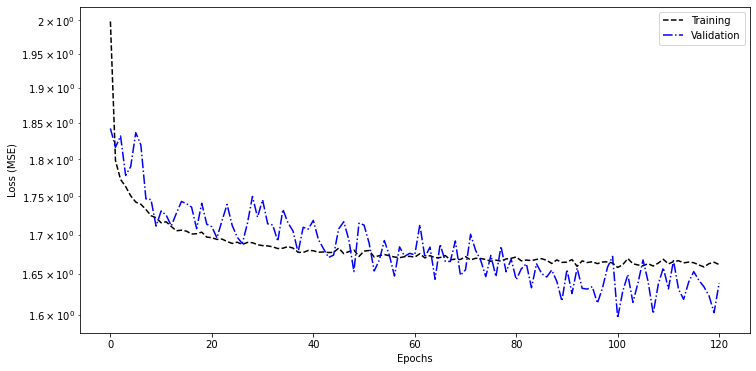

time: 487 ms (started: 2021-04-18 19:05:12 +00:00)


In [170]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_ANN)

In [171]:
# Calling trained model for predictions:
Y_test_predictions_ANN = pd.DataFrame(model_best_ANN.predict(X_test_ANN),index=X_test_ANN.index)
Y_train_predictions_ANN = pd.DataFrame(model_best_ANN.predict(X_train_ANN),index=X_train_ANN.index)

# Inverse One Hot Encoding
# 1. Find highest value in line and set to one, rest will be zero
# 2. Reconvert it to string weather description
# 3. Add prediction to list Y_test_predictions_ANN_decoded_str (same for int)

Y_test_predictions_ANN_decoded_int, Y_test_predictions_ANN_decoded_str = inverse_transform_1hot(Y_test_predictions_ANN, y_train_ANN.columns)
Y_test_ANN_decoded_int,             Y_test_ANN_decoded_str             = inverse_transform_1hot(y_test_ANN, y_train_ANN.columns)
Y_train_predictions_ANN_decoded_int, Y_train_predictions_ANN_decoded_str = inverse_transform_1hot(Y_train_predictions_ANN, y_train_ANN.columns)
Y_train_ANN_decoded_int,             Y_train_ANN_decoded_str             = inverse_transform_1hot(y_train_ANN, y_train_ANN.columns)

time: 23.6 s (started: 2021-04-18 19:05:12 +00:00)


In [172]:
print(len(Y_test_predictions_ANN_decoded_int))
print(len(Y_test_ANN_decoded_int))
pd.Series(Y_test_predictions_ANN_decoded_str).value_counts()
for i in range(len(Y_test_ANN_decoded_int)):
  print("True: " + Y_test_ANN_decoded_str[i] + "                    Predicted: "+ Y_test_predictions_ANN_decoded_str[i])

4583
4583
True: broken clouds                    Predicted: broken clouds
True: overcast clouds                    Predicted: mist
True: overcast clouds                    Predicted: mist
True: mist                    Predicted: mist
True: mist                    Predicted: mist
True: mist                    Predicted: mist
True: mist                    Predicted: mist
True: light rain                    Predicted: mist
True: light rain                    Predicted: mist
True: light rain                    Predicted: mist
True: light rain                    Predicted: mist
True: light rain                    Predicted: mist
True: light rain                    Predicted: mist
True: light rain                    Predicted: mist
True: light rain                    Predicted: mist
True: light rain                    Predicted: mist
True: light rain                    Predicted: mist
True: light rain                    Predicted: mist
True: light rain                    Predicted: mist
True

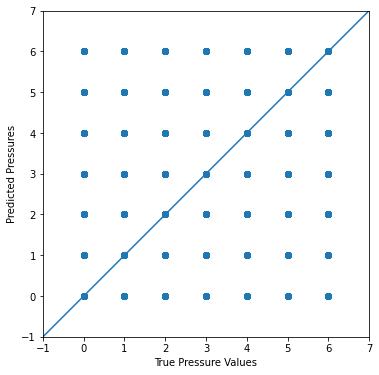

time: 595 ms (started: 2021-04-18 19:05:37 +00:00)


In [173]:
# Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(Y_test_ANN_decoded_int, Y_test_predictions_ANN_decoded_int)
plt.xlabel('True Pressure Values')
plt.ylabel('Predicted Pressures')
lims = [-1, 7]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)
#plt.savefig("abc.png")
#files.download("abc.png") 


In [174]:
#Calculating R2 value:"
r2_test = r2_score(y_test_ANN, Y_test_predictions_ANN)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.02
time: 6.49 ms (started: 2021-04-18 19:05:38 +00:00)


Percentage of right predicted values: 35.32 %


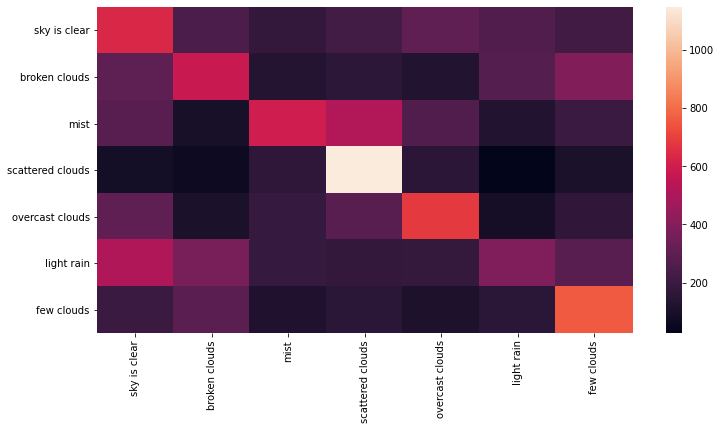

time: 342 ms (started: 2021-04-18 19:05:38 +00:00)


In [175]:
cm_train_NN = confusion_matrix(Y_train_ANN_decoded_int, Y_train_predictions_ANN_decoded_int)
axa = sns.heatmap(cm_train_NN, annot=False, xticklabels=xy_labels, yticklabels=xy_labels)
print("Percentage of right predicted values: {:.2f} %" .format(get_percentage_of_right_predicted_values(cm_train_NN)))

Percentage of right predicted values: 24.87 %


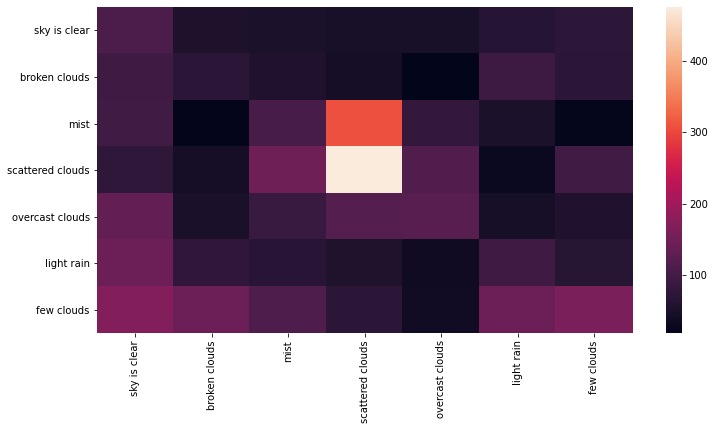

time: 646 ms (started: 2021-04-18 19:05:38 +00:00)


In [176]:
cm_test_NN = confusion_matrix(Y_test_ANN_decoded_int, Y_test_predictions_ANN_decoded_int)
axa = sns.heatmap(cm_test_NN, annot=False, xticklabels=xy_labels, yticklabels=xy_labels)
print("Percentage of right predicted values: {:.2f} %" .format(get_percentage_of_right_predicted_values(cm_test_NN)))

## Correlation with flight delay

For New York we investigate if there is a correlation between bad weather and flight delays in 2016.

In [177]:
data_flight_delay

,FL_DATE,CARRIER,FL_NUM,ORIGIN,DEST,DEP_DELAY,ARR_DELAY
0,01.01.2016,AA,45,JFK,SEA,-60.0,-250.0
1,02.01.2016,AA,45,JFK,SEA,640.0,560.0
2,03.01.2016,AA,45,JFK,SEA,310.0,560.0
3,04.01.2016,AA,45,JFK,SEA,460.0,370.0
4,05.01.2016,AA,45,JFK,SEA,60.0,-180.0
...,...,...,...,...,...,...,...
99340,22.12.2016,VX,409,JFK,LAX,270.0,580.0
99341,22.12.2016,VX,411,JFK,LAX,800.0,1250.0
99342,22.12.2016,VX,413,JFK,LAX,410.0,500.0
99343,22.12.2016,VX,415,JFK,LAX,170.0,480.0


time: 31.9 ms (started: 2021-04-18 19:05:39 +00:00)


In [178]:
# Filter flight delay dataset
filter_origin = data_flight_delay['ORIGIN'].isin(['JFK'])
filter_dep_delay = data_flight_delay['DEP_DELAY'] > 0
data_flight_delay=data_flight_delay[filter_origin & filter_dep_delay]

# convert the column to datetime type:
datetime_series_fd = pd.to_datetime(data_flight_delay['FL_DATE'], format='%d.%m.%Y')

#Create datetime index and pass it:
datetime_index_fd = pd.DatetimeIndex(datetime_series_fd.values)
data_flight_delay = data_flight_delay.set_index(datetime_index_fd)
#data_flight_delay = data_flight_delay.drop('FL_DATE',axis=1)


time: 40.1 ms (started: 2021-04-18 19:05:39 +00:00)


In [179]:
#Calculate mean dep delay values for each day
data_flight_delay = data_flight_delay.sort_index()
data_flight_delay
mean_dep_delay = data_flight_delay['DEP_DELAY'].groupby(data_flight_delay.index).mean()
mean_dep_delay

2016-01-01    206.666667
2016-01-02    301.798561
2016-01-03    368.407643
2016-01-04    374.000000
2016-01-05    276.417910
                 ...    
2016-12-27    189.449541
2016-12-28    348.421053
2016-12-29    439.635036
2016-12-30    344.107143
2016-12-31    301.630435
Name: DEP_DELAY, Length: 366, dtype: float64

time: 19.1 ms (started: 2021-04-18 19:05:39 +00:00)


In [180]:
import math
corr_plot_values = pd.concat([mean_dep_delay, weather_data_flight_delay],axis=1, join='inner')
corr_plot_values.columns = ['mean_dep_delay','weather_description']
#print(corr_plot_values['mean_dep_delay'].iloc[24:48])
for i in range(len(mean_dep_delay.index)):
  corr_plot_values['mean_dep_delay'].loc[(dt.date(2016,1,1)+dt.timedelta(days=i)).strftime('%Y-%m-%d')] = mean_dep_delay[i]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



time: 286 ms (started: 2021-04-18 19:05:39 +00:00)


In [181]:
median = corr_plot_values.groupby(['weather_description']).median()


time: 6.67 ms (started: 2021-04-18 19:05:39 +00:00)


(0.0, 900.0)

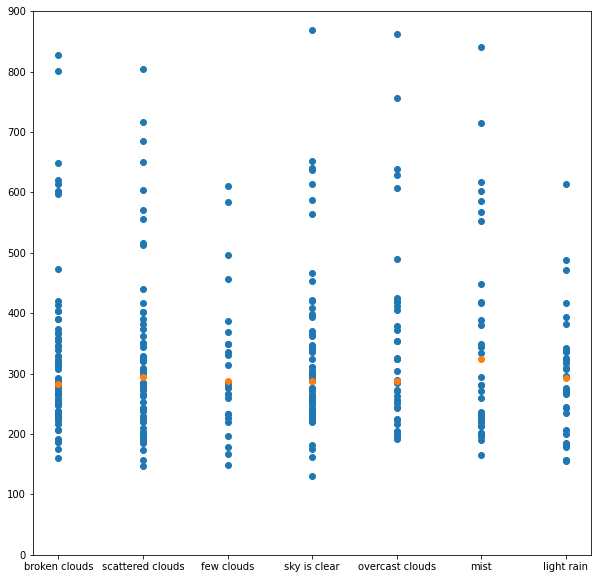

time: 267 ms (started: 2021-04-18 19:05:39 +00:00)


In [182]:
val = corr_plot_values['mean_dep_delay']
nam = corr_plot_values['weather_description']
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(nam,val)
ax.scatter(nam.value_counts().keys(),median)
ax.set_ylim(0, 900)


Text(0, 0.5, 'relativ delay [%]')

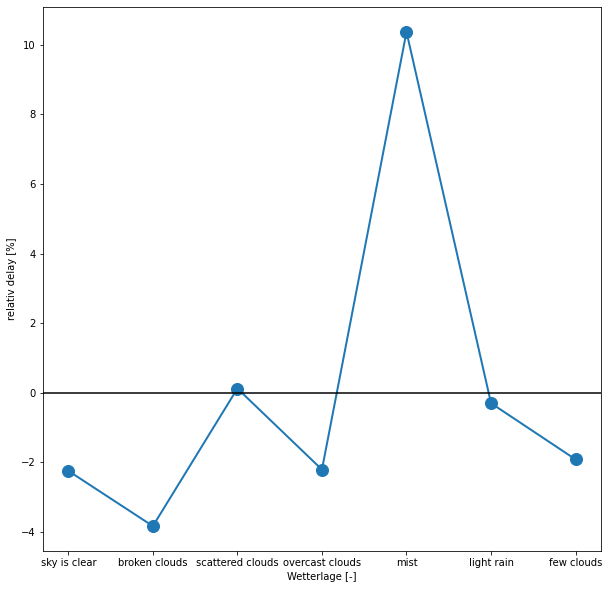

time: 272 ms (started: 2021-04-18 19:05:39 +00:00)


In [183]:
# Only median plot
mean_delay = median.mean()
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(nam.value_counts().keys(),(median/mean_delay-1)*100,marker='o', linewidth=2, markersize=12)
ax.axhline(y=0, color='k')
ax.set_xlabel("Wetterlage [-]")
ax.set_ylabel("relativ delay [%]")

So next time you go on vacation by plane, take the weather data of the next days, put it into the model and see if you have time for an extra coffee at the airport!

# 5. Testing Phase III: Model Regularization and Hyperparameter optimization

In this section, the optimization process of the models is discussed. For reasons of clarity, the optimization was performed directly after the model. Therefore, this section aims more at the approach and the difficulties encountered

## Temperature forecasting

I started with a simple model without BatchNormalization and LeackyReLU layers. Then I increased number of neurons and number of hidden layers to increase prediction accuracy. R^2 value was 94% even for small number of hidden layers and neurons






Loss with small number of neurons and 1 hidden layer:

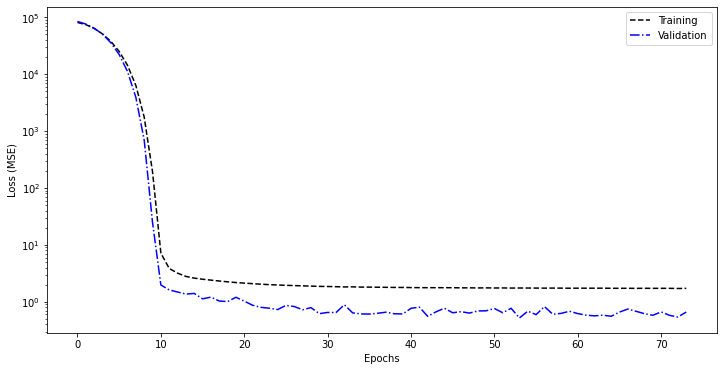


Loss and temperature profile with optimal Parameters based on RandomizedSearchCV()

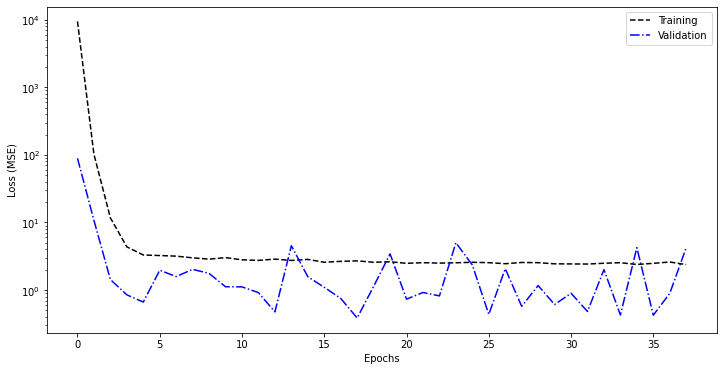

Randomized Search CV

To test as many combinations of hyperparameters as possible I used sklearn's RandomizedSearchCV function, which unlike GridSearch() only tests randomly selected parameter combinations.

## Weather description forecasting



Predicting the weather description presented many challenges. First of all, it is a multiclass classification, i.e. the prediction of a label with several classes. However, since these classes are available as strings in the raw data set, they have to be converted into a number format first. This cannot simply be done with a LabelEncoder(), because it only assigns an 'int' value for each string. This assignment leads to the formation of a ranking between the weather descriptions, which does not exist in reality. Thus I used the one-hot encoder for encoding. Instead of one label with several values, you get several labels with the value 0 or 1. Each combination of 0 and 1 occurs only once and represents a description of the weather.

When analyzing the data, it was especially noticeable that the data set consists of unbalanced data regarding the weather description. Some descriptions occurred only once, others over 10000 times. Without pre-processing, such training data would lead to a stronger bias towards the more dominant weather descriptions.

After many opimization attempts, I managed to capture the training data as well as possible with the model. However, the test data were not predicted rudimentarily well for any of the combinations. After re-analyzing the data, I concluded that it could be that different combinations of pressure, humidity, and wind conditions could lead to the same weather patterns. Thus, for a clear and unambiguous prediction of the weather, one would need other features such as cloud density or rain probability. To validate this, I performed the "golden test" and reduced the training data to 3 samples. The model was able to adjust its parameters to capture 100% of the training data (which is what I expected). It showed up that already with more than 10 samples the wrongly predicted weather descriptions increased, which I explain with the fact that it must come already under this small number of samples to contradictions in the combination of weather data and weather description.


---



Predictions with unbalanced data:

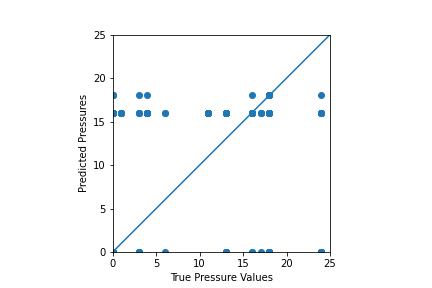

# 6. Evaluation of the model predictions

The methods used differed, sometimes significantly, in prediction accuracy and computation time. With good quality data, very good prediction results can be achieved. Furthermore, it was noticed that artificial neural networks can also make good predictions with low complexity. Nevertheless, predictions can only be as good as the data on which they are based, which is why all predictions made by data-driven methods must be critically scrutinized at all times.

# 7. Lessons Learnt and Conclusions

In this project, I was able to gain a lot of valuable experience with data-driven methods. Due to the large number of models, one had a good starting point to then, in the next step, find and apply additional methods and models tailored to one's own data set in one's own research. It should be noted that while the optimization of hyperparameters play a crucial role for the models, the preparation and precise analysis of the data is even more important. Only then can knowledge be gained about which models and model settings should be chosen. Furthermore, it should be critically questioned whether the prediction of a variable with the data of the data set is also meaningful and unambiguous. Particularly exciting was the processing of strings, which was associated with unexpectedly high additional effort. In summary I can say that I am now familiar with the basic data processing methods and have acquired enough knowledge to be able to continue with more advanced projects in the future.